In [8]:
!pip install mplfinance

In [9]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
# from keras_self_attention import SeqSelfAttention
from datetime import datetime
import mplfinance as mpf
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,Bidirectional, Conv1D, ConvLSTM2D, Flatten, Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter('ignore')

In [10]:
# URL of the S&P 500 companies list
SP500_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Load the S&P 500 table from the webpage
sp500_table = pd.read_html(SP500_URL)[0]
print("First two rows of the S&P 500 table:")
print(sp500_table.head(2))

# Filter the tickers that were added before 2010
start_date = datetime(2010, 1, 1)
sp500_tickers = sp500_table[sp500_table['Date added'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') < start_date)]['Symbol'].tolist()

# Display the number of tickers
print(f"Number of S&P 500 tickers added before {start_date.year}: {len(sp500_tickers)}")


First two rows of the S&P 500 table:
  Symbol     Security  GICS Sector         GICS Sub-Industry  \
0    MMM           3M  Industrials  Industrial Conglomerates   
1    AOS  A. O. Smith  Industrials         Building Products   

   Headquarters Location  Date added    CIK Founded  
0  Saint Paul, Minnesota  1957-03-04  66740    1902  
1   Milwaukee, Wisconsin  2017-07-26  91142    1916  
Number of S&P 500 tickers added before 2010: 290


In [11]:
# Define the start date for downloading data
START_DATE = "2010-01-01"

# Download historical data for the S&P 500 tickers
print("Downloading historical data for S&P 500 tickers...")
sp500_data = yf.download(sp500_tickers, start=START_DATE, interval='1d', group_by='ticker')

# Display a summary description of the downloaded data
print("Summary of the downloaded S&P 500 data:")
sp500_data.describe()

[*********************100%%**********************]  290 of 290 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2023-12-22)')



Summary of the downloaded S&P 500 data:


IRM                                                      \
              Open         High          Low        Close    Adj Close   
count  3518.000000  3518.000000  3518.000000  3518.000000  3518.000000   
mean     34.790353    35.150875    34.422755    34.802061    24.550876   
std       9.722523     9.822873     9.629791     9.741907    13.256349   
min      18.715342    18.890944    18.419594    18.715342     7.963017   
25%      28.290051    28.622921    28.022181    28.317930    13.982404   
50%      32.529999    32.814428    32.130001    32.536175    22.447252   
75%      37.880001    38.130001    37.500000    37.830002    26.067153   
max      69.250000    69.589996    69.050003    69.559998    69.559998   

                             RTX                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.518000e+03  3518.000000  3518.000000  3518.000000  3518.000000  ...   
mean   1.970956e+06    70.100610    70.704519    69.462837    70.093322  ...   
std    1.478965e+06    15.845137    15.972295    15.715611    15.839317  ...   
min    1.027770e+05    39.804909    40.446823    39.572060    39.786030  ...   
25%    1.181050e+06    57.628078    58.371617    57.058844    57.614853  ...   
50%    1.588700e+06    70.629326    71.044682    70.100346    70.534317  ...   
75%    2.284125e+06    82.257502    83.044371    81.438366    82.259285  ...   
max    2.252590e+07   105.849998   106.019997   104.279999   104.970001  ...   

               SYK                                                  NSC  \
               Low        Close    Adj Close        Volume         Open   
count  3518.000000  3518.000000  3518.000000  3.518000e+03  3518.000000   
mean    140.725142   142.127970   134.447042  1.537448e+06   138.959505   
std      76.996502    77.857968    79.248840  8.143404e+05    70.545393   
min      42.740002    42.880001    36.041458  1.391740e+05    46.730000   
25%      66.987501    67.392498    59.262030  1.015175e+06    75.447502   
50%     120.700001   121.310001   111.890873  1.327500e+06   111.689999   
75%     206.382496   208.512505   200.959980  1.827900e+06   199.865002   
max     303.209991   305.089996   304.231537  1.100020e+07   298.500000   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3518.000000  3518.000000  3518.000000  3518.000000  3.518000e+03  
mean    140.433007   137.560252   138.994517   125.040508  1.923127e+06  
std      71.309581    69.800599    70.509681    72.676504  1.039357e+06  
min      47.290001    46.180000    46.310001    33.724228  1.757790e+05  
25%      76.202497    74.662502    75.485003    59.591878  1.225125e+06  
50%     112.864998   111.035000   111.769997    95.581009  1.665650e+06  
75%     201.745003   197.735004   200.054996   186.717121  2.342525e+06  
max     299.200012   293.980011   297.709991   284.688995  1.218970e+07  

[8 rows x 1740 columns]

In [12]:
# Define the asset of interest
ASSET_NAME = 'AAPL'

# Extract data for the specified asset
test_asset = sp500_data[ASSET_NAME]

# Display the data for the specified asset
print(f"Data for {ASSET_NAME}:")
print(test_asset)

Data for AAPL:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.478998   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.490199   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.386963   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.375157   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.417540   
...                ...         ...         ...         ...         ...   
2023-12-18  196.089996  196.630005  194.389999  195.889999  195.889999   
2023-12-19  196.160004  196.949997  195.889999  196.940002  196.940002   
2023-12-20  196.899994  197.679993  194.830002  194.830002  194.830002   
2023-12-21  196.100006  197.080002  193.500000  194.679993  194.679993   
2023-12-22  195.179993  195.410004  194.360001  194.471893  194.471893   

               Volume 

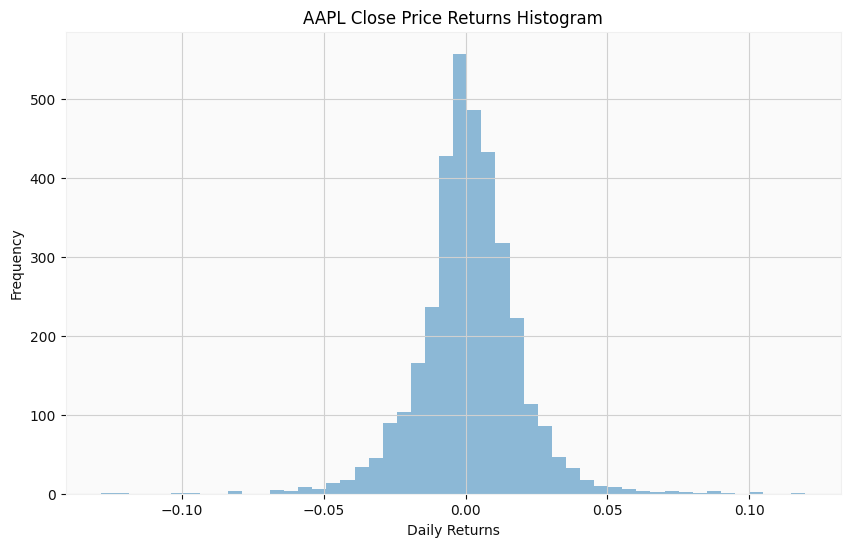

In [13]:
# Calculating the daily returns for the specified asset
returns = test_asset['Adj Close'].pct_change().dropna()

# Plotting the histogram for the daily returns
plt.figure(figsize=(10, 6))
returns.plot.hist(bins=50, alpha=0.5)
plt.title(f'{ASSET_NAME} Close Price Returns Histogram')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

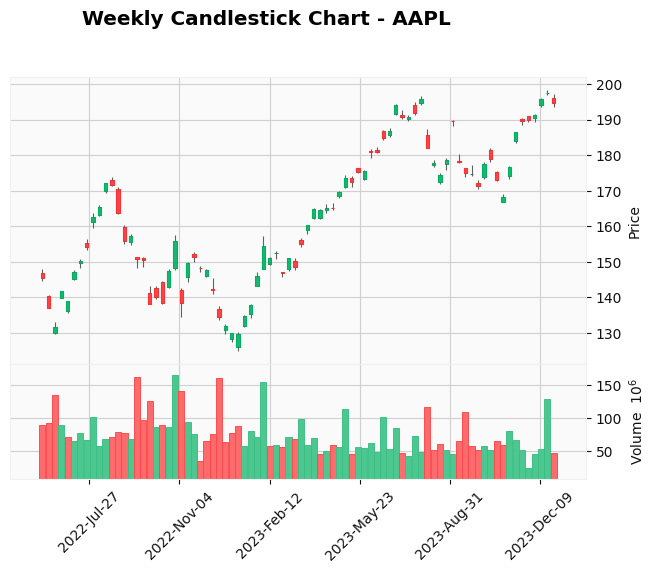

In [14]:
# Define the start and end dates for the data
START_DATE = '2022-06-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')  # Current date

# Downloading stock data for the specified asset
stock_data = yf.download(ASSET_NAME, start=START_DATE, end=END_DATE, progress=False)

# Resampling the data to weekly frequency
stock_data_weekly = stock_data.resample('W').last()

# Plotting the weekly candlestick chart
mpf.plot(stock_data_weekly, type='candle', style='yahoo', volume=True, show_nontrading=True, title=f'Weekly Candlestick Chart - {ASSET_NAME}')


In [21]:
def create_sequences(data, seq_length):
    """
    Create sequences and labels from time series data.

    Args:
    data (array-like): The time series data.
    seq_length (int): The length of the sequences.

    Returns:
    tuple: Arrays of sequences and their corresponding labels.
    """
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        # Extract the sequence and the label
        sequence = data[i:i + seq_length]
        label = data[i + seq_length]

        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [16]:
def create_model(model_type, seq_length):
    """
    Create a neural network model based on the specified type.

    Args:
    model_type (str): The type of the model (e.g., 'LSTM', 'GRU', 'BiLSTM', 'ConvLSTM', 'CNN', 'MLP').
    seq_length (int): The input sequence length.

    Returns:
    Sequential: The compiled neural network model.
    """
    model = Sequential()
    input_shape = (seq_length, 1)

    if model_type == 'LSTM':
        model.add(LSTM(50, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=input_shape))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(50), input_shape=input_shape))
    elif model_type == 'ConvLSTM':
        model.add(Conv1D(filters=50, kernel_size=3, activation='elu', input_shape=input_shape))
        model.add(LSTM(50))
    elif model_type == 'CNN':
        model.add(Conv1D(filters=50, kernel_size=3, activation='elu', input_shape=input_shape))
        model.add(Flatten())
    elif model_type == 'MLP':
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(50, activation='elu'))  # First Dense layer with 50 units
        model.add(Dense(50, activation='elu'))  # Second Dense layer with 50 units

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [17]:
def plot_loss(history, model_name):
    """
    Plot the training and validation loss of a model.

    Args:
    history: The history object returned by the fit method of a model.
    model_name (str): The name of the model.

    """
    # Plotting training loss
    plt.plot(history.history['loss'], label='Train Loss')

    # Plotting validation loss
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')

    # Setting the title, labels, and legend
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Displaying the plot
    plt.show()


In [18]:
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate a model on the test set and calculate MAE, MSE, and MAPE.

    Args:
    model: The trained model to evaluate.
    X_test (array-like): Test data features.
    y_test (array-like): True values for the test data.
    scaler: Scaler object used for inverse transforming predictions.

    Returns:
    tuple: Mean Absolute Error (MAE), Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE).
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and true labels to original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    return mae, mse, mape


In [19]:
def naive_prediction(data):
    """
    Create a naive prediction by shifting the data by one time step.

    Args:
    data (array-like): The time series data from which to generate the naive prediction.

    Returns:
    array-like: The naive prediction, with the same shape as the input data.
    """
    # Shift the data by one time step
    return np.roll(data, shift=1)


[*********************100%%**********************]  5 of 5 completed
cross validation length is 587
(2308, 1) (2308, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


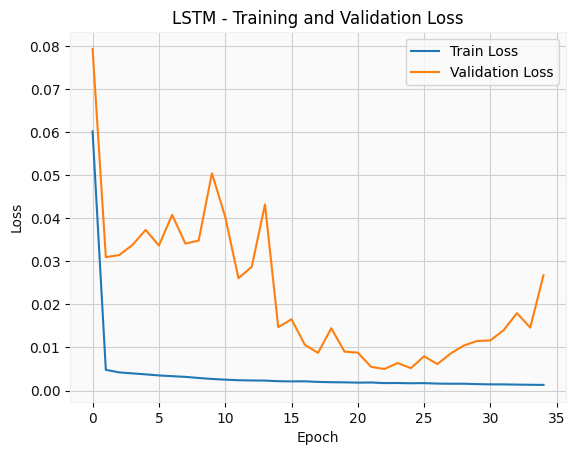

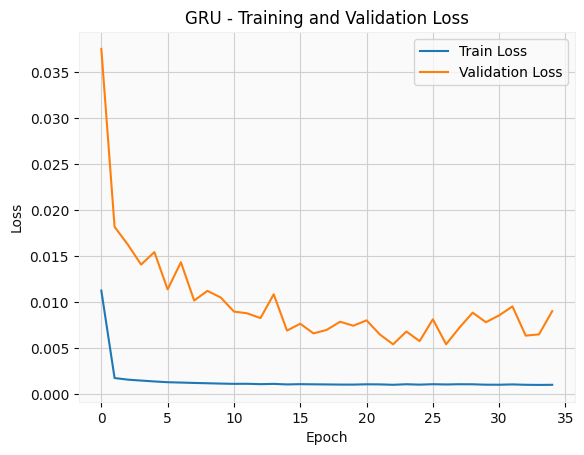

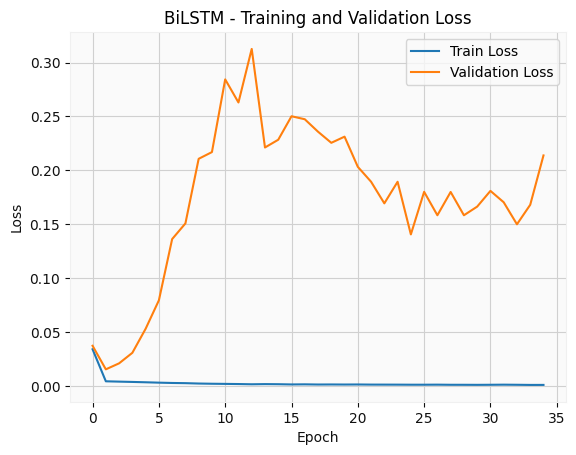

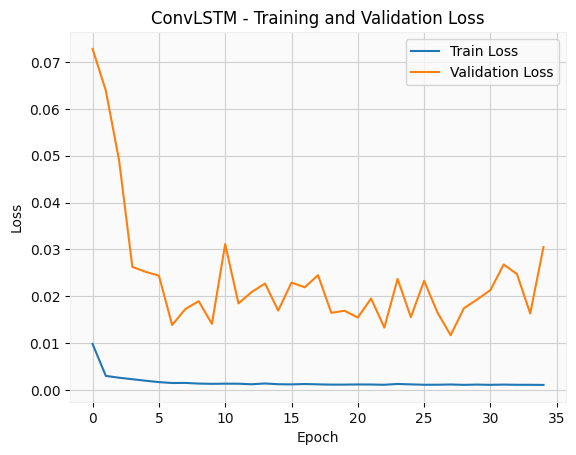

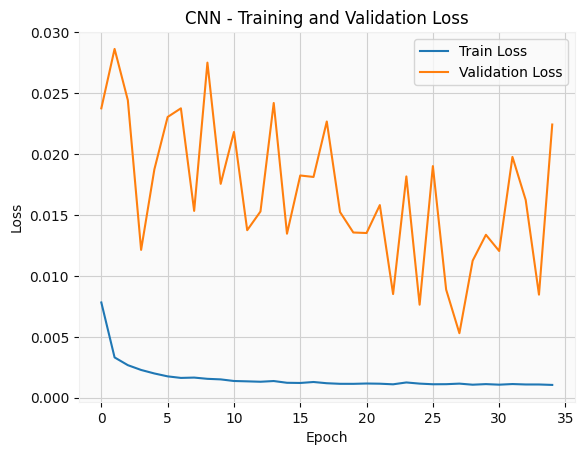

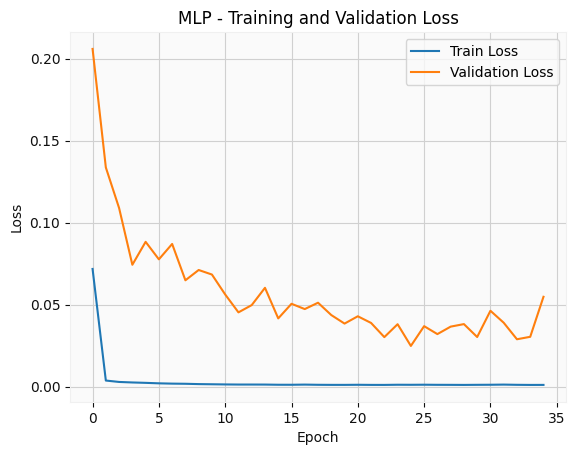

72/72 [==============================] - 0s 2ms/step
LSTM - MAE: 0.92, MSE: 2.01, MAPE: 2.71%
GRU - MAE: 0.51, MSE: 0.68, MAPE: 1.51%
BiLSTM - MAE: 2.55, MSE: 16.08, MAPE: 7.30%
ConvLSTM - MAE: 0.98, MSE: 2.29, MAPE: 2.87%
CNN - MAE: 0.93, MSE: 1.69, MAPE: 2.79%
MLP - MAE: 1.30, MSE: 4.12, MAPE: 3.76%
Naive Prediction - MAE: 0.26, MSE: 0.44, MAPE: 0.89%
cross validation length is 587
(2308, 1) (2308, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


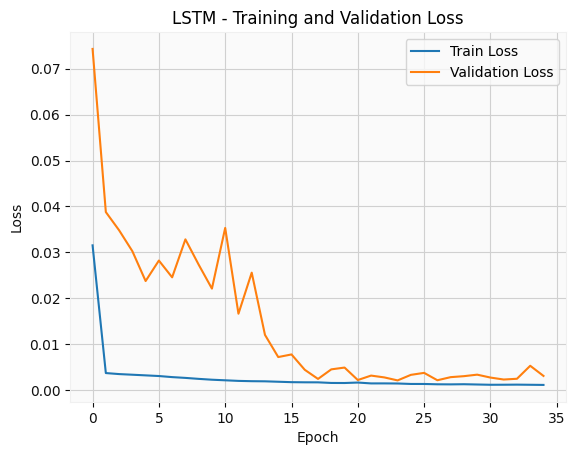

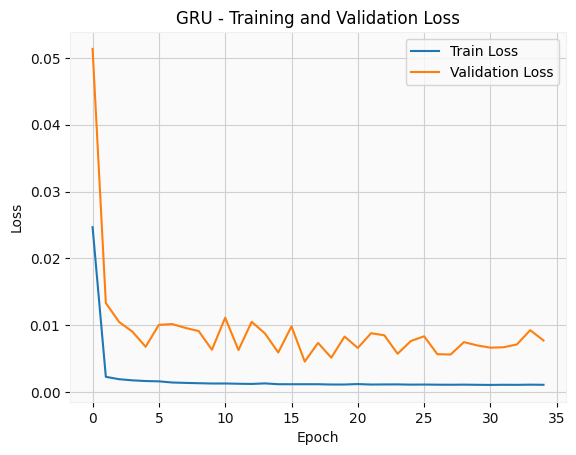

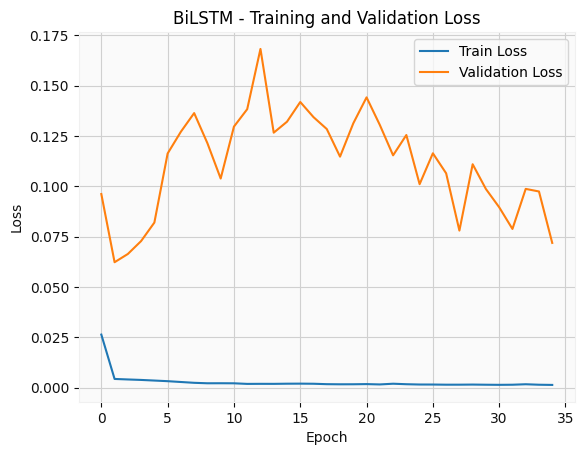

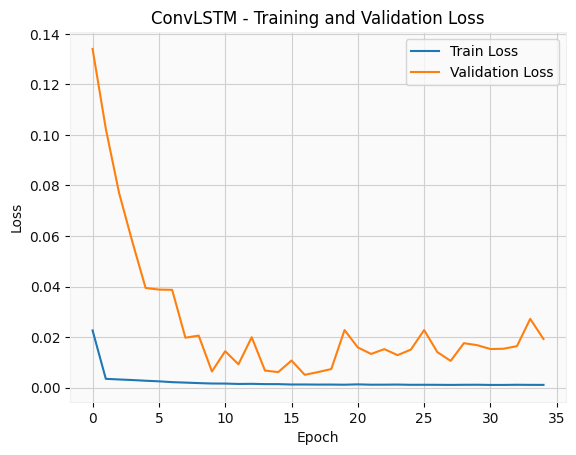

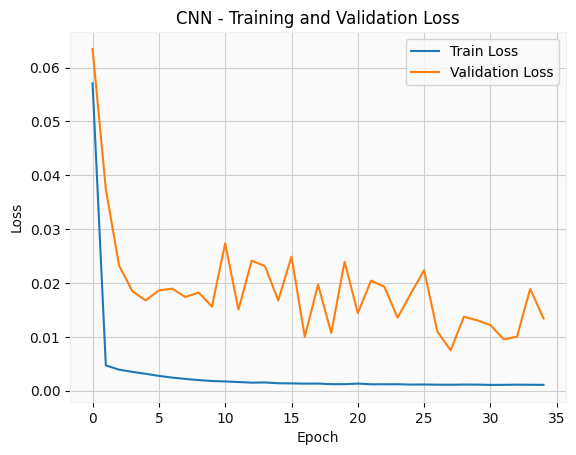

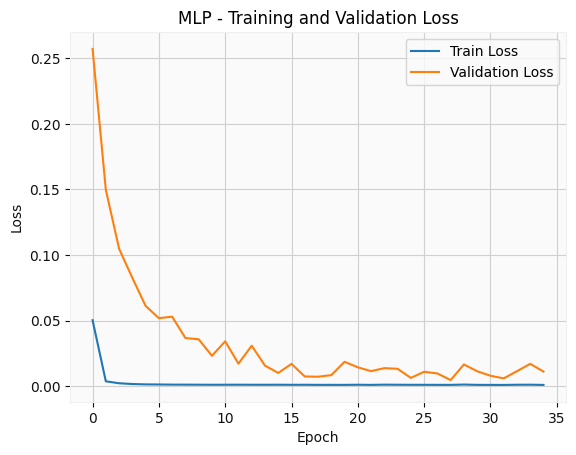

72/72 [==============================] - 0s 2ms/step
LSTM - MAE: 0.33, MSE: 0.23, MAPE: 1.06%
GRU - MAE: 0.47, MSE: 0.58, MAPE: 1.40%
BiLSTM - MAE: 1.32, MSE: 5.40, MAPE: 3.67%
ConvLSTM - MAE: 0.68, MSE: 1.45, MAPE: 1.92%
CNN - MAE: 0.64, MSE: 1.01, MAPE: 1.87%
MLP - MAE: 0.58, MSE: 0.85, MAPE: 1.71%
Naive Prediction - MAE: 0.26, MSE: 0.44, MAPE: 0.89%
cross validation length is 587
(2308, 1) (2308, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


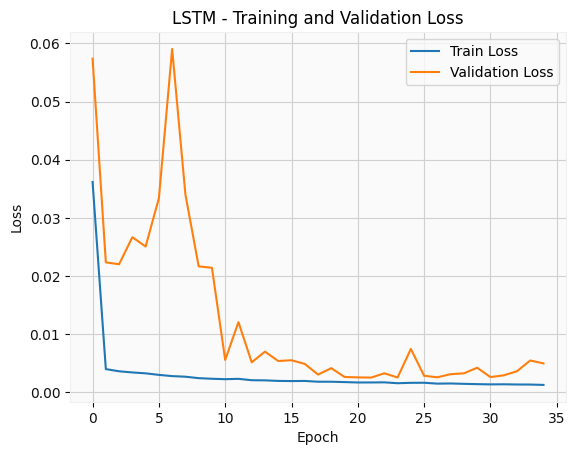

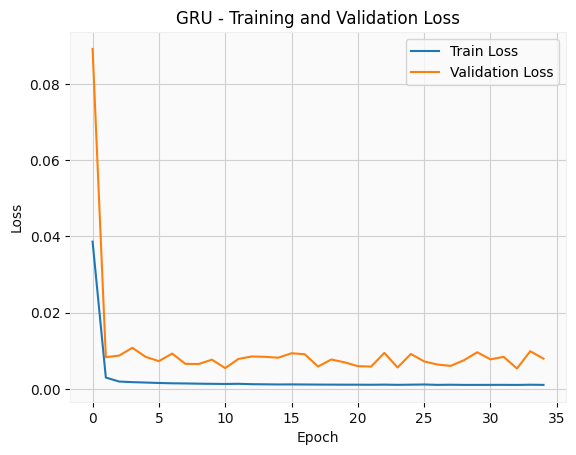

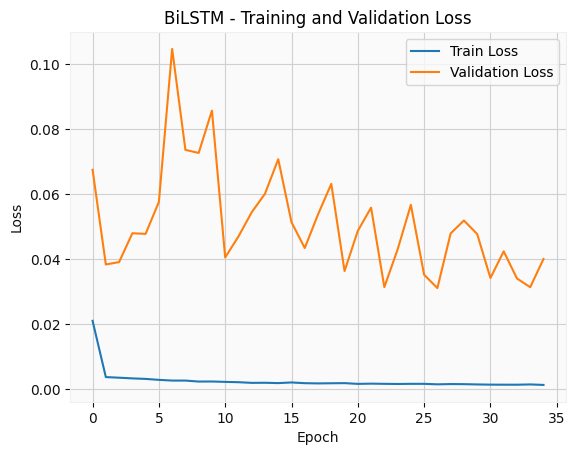

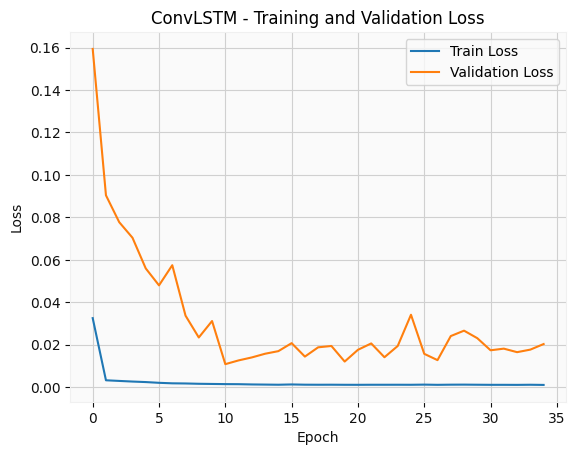

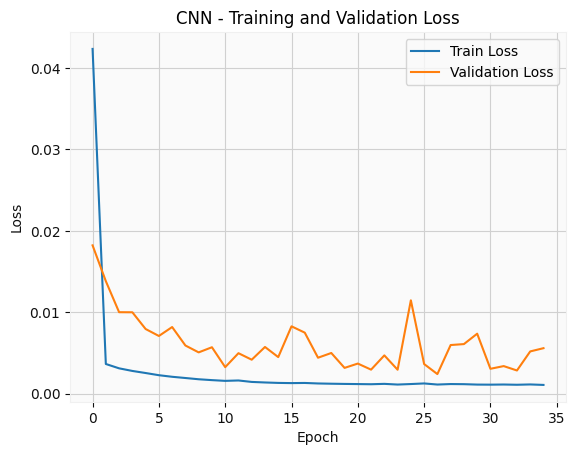

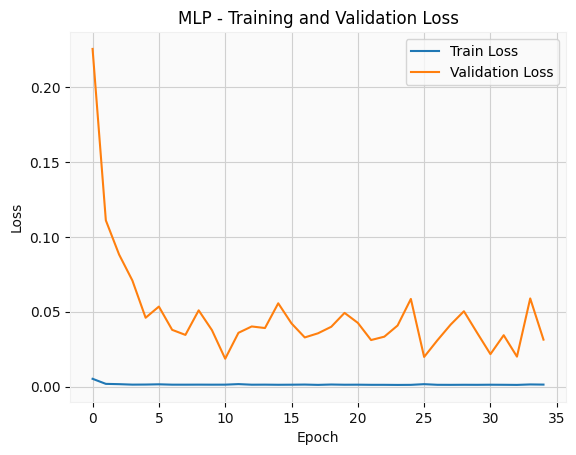

72/72 [==============================] - 0s 2ms/step
LSTM - MAE: 0.40, MSE: 0.37, MAPE: 1.22%
GRU - MAE: 0.48, MSE: 0.60, MAPE: 1.42%
BiLSTM - MAE: 1.08, MSE: 3.01, MAPE: 3.09%
ConvLSTM - MAE: 0.73, MSE: 1.53, MAPE: 2.10%
CNN - MAE: 0.45, MSE: 0.42, MAPE: 1.40%
MLP - MAE: 0.91, MSE: 2.35, MAPE: 2.56%
Naive Prediction - MAE: 0.26, MSE: 0.44, MAPE: 0.89%
cross validation length is 587
(2308, 1) (2308, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


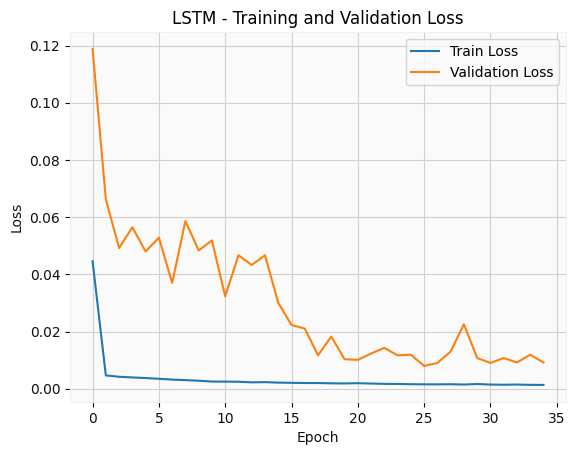

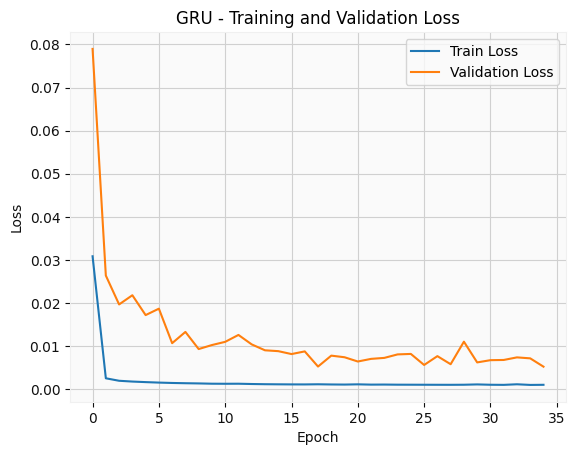

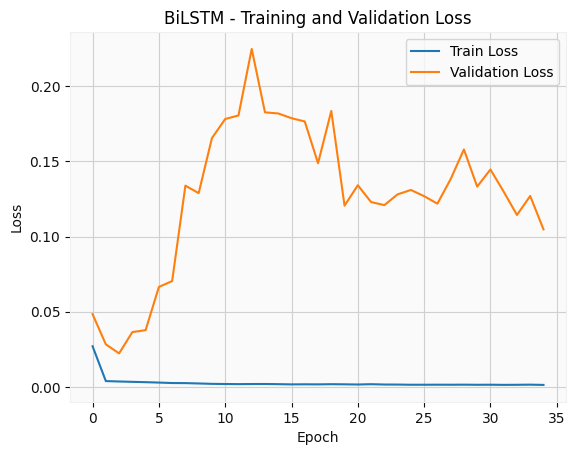

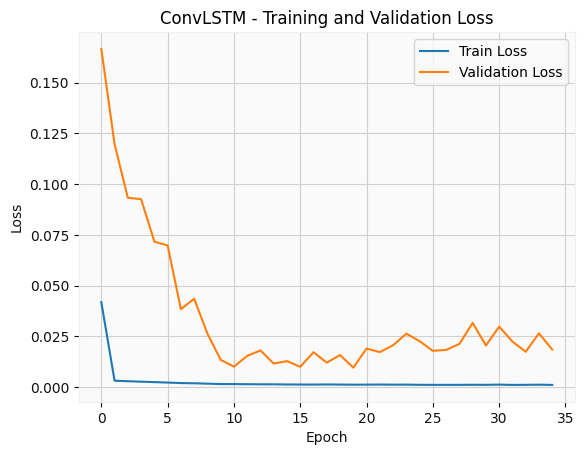

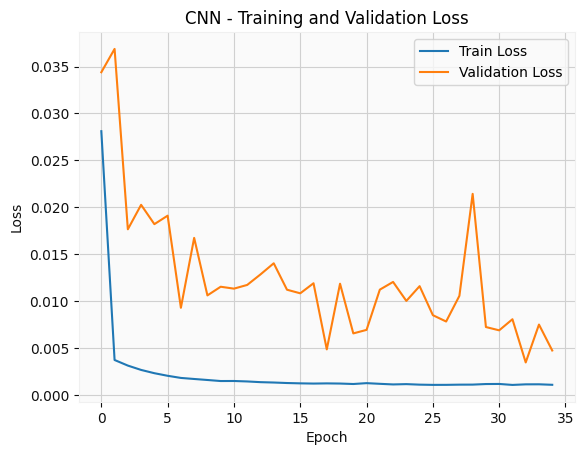

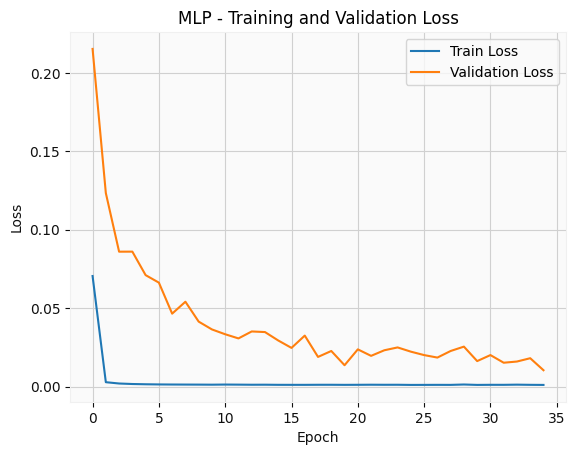

72/72 [==============================] - 0s 2ms/step
LSTM - MAE: 0.49, MSE: 0.69, MAPE: 1.47%
GRU - MAE: 0.38, MSE: 0.40, MAPE: 1.15%
BiLSTM - MAE: 1.57, MSE: 7.87, MAPE: 4.34%
ConvLSTM - MAE: 0.65, MSE: 1.39, MAPE: 1.87%
CNN - MAE: 0.38, MSE: 0.36, MAPE: 1.17%
MLP - MAE: 0.56, MSE: 0.78, MAPE: 1.72%
Naive Prediction - MAE: 0.26, MSE: 0.44, MAPE: 0.89%
cross validation length is 587
(2308, 1) (2308, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


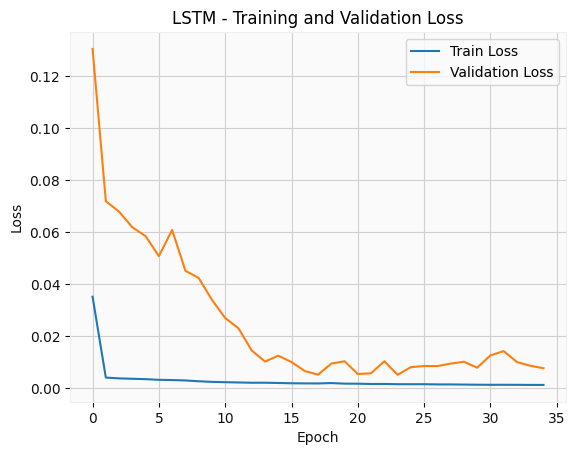

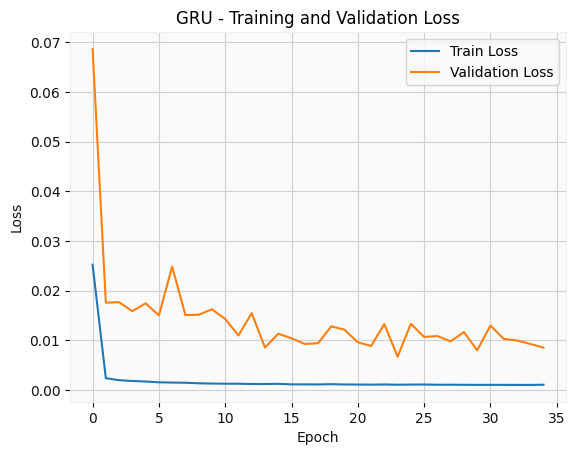

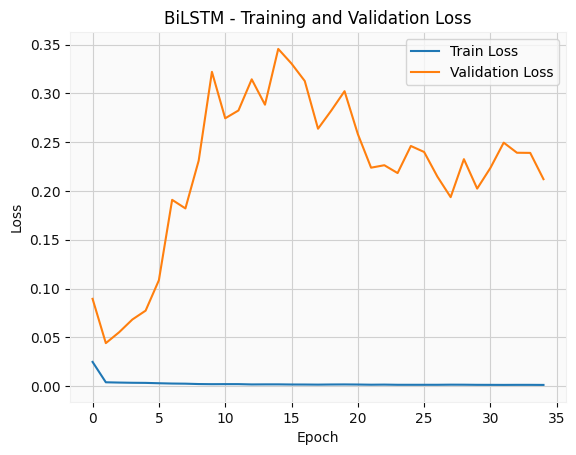

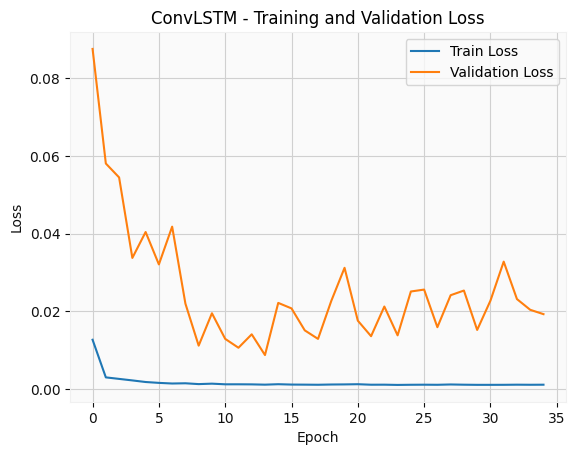

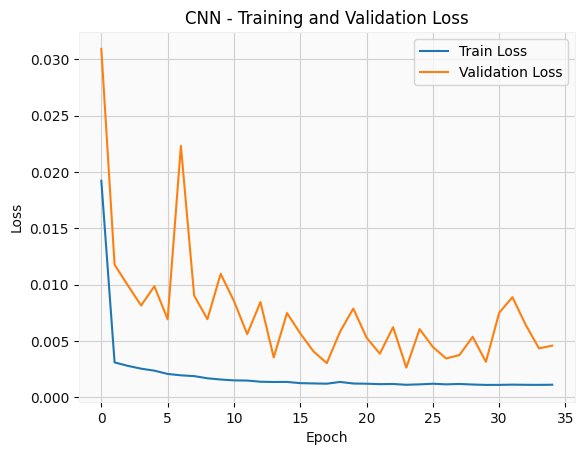

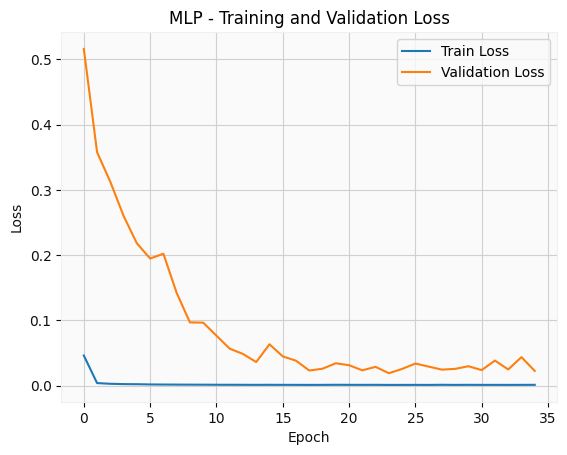

72/72 [==============================] - 0s 2ms/step
LSTM - MAE: 0.44, MSE: 0.57, MAPE: 1.31%
GRU - MAE: 0.46, MSE: 0.64, MAPE: 1.34%
BiLSTM - MAE: 2.23, MSE: 15.94, MAPE: 6.08%
ConvLSTM - MAE: 0.67, MSE: 1.45, MAPE: 1.89%
CNN - MAE: 0.39, MSE: 0.34, MAPE: 1.19%
MLP - MAE: 0.73, MSE: 1.69, MAPE: 2.05%
Naive Prediction - MAE: 0.26, MSE: 0.44, MAPE: 0.89%
cross validation length is 1173
(5216, 1) (5216, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


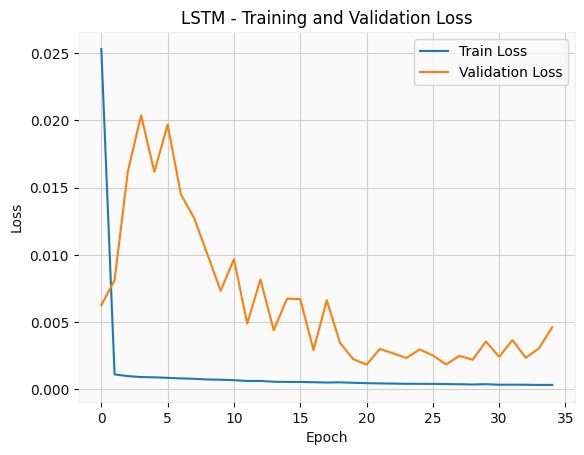

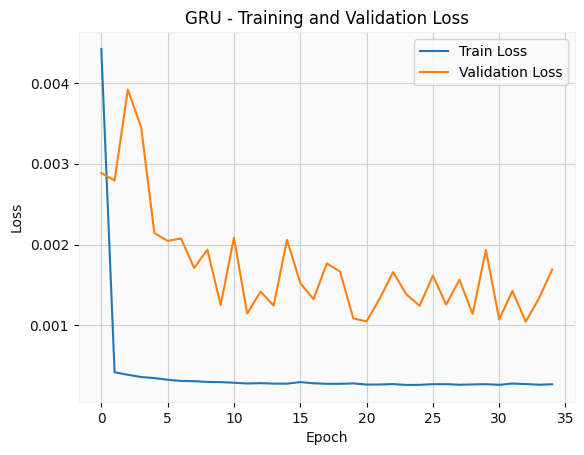

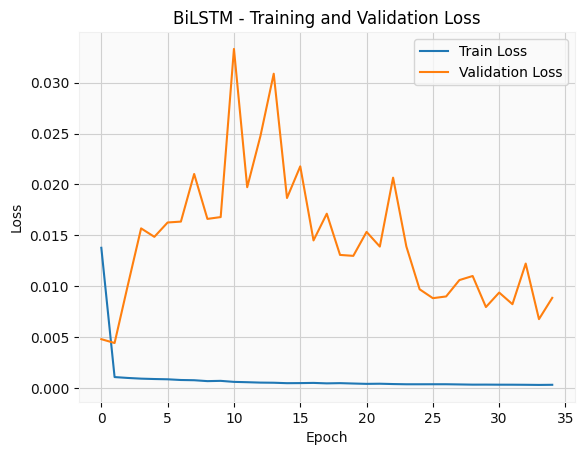

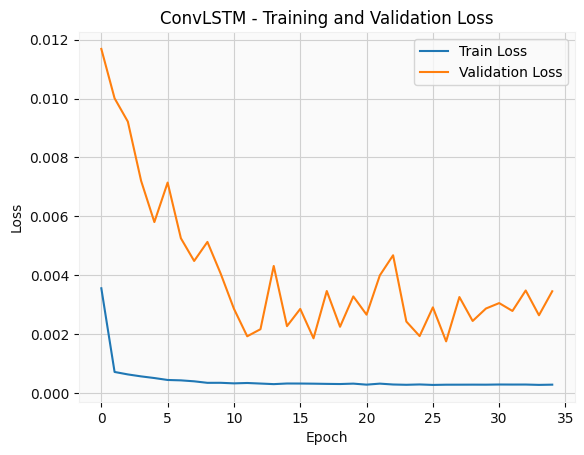

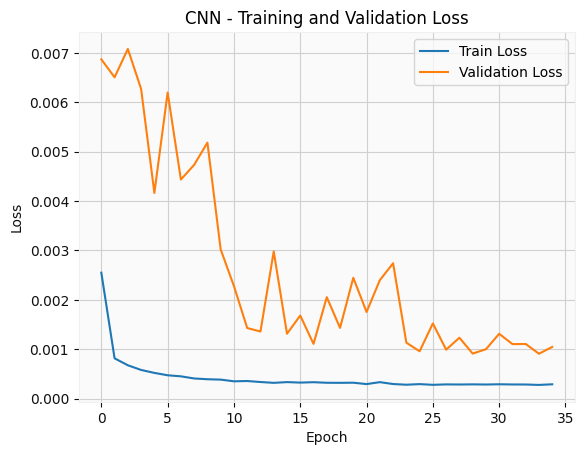

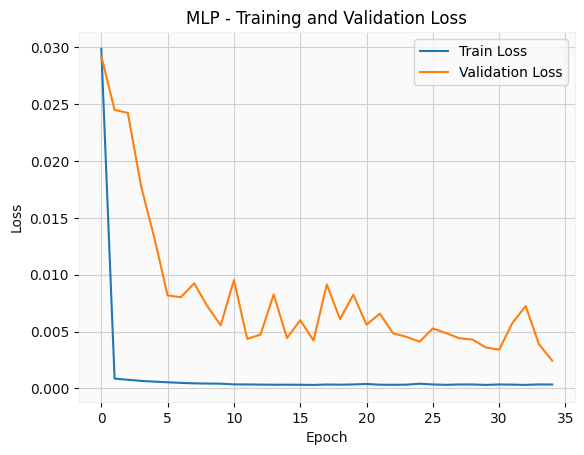

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 1.07, MSE: 2.12, MAPE: 2.15%
GRU - MAE: 0.64, MSE: 0.78, MAPE: 1.34%
BiLSTM - MAE: 1.39, MSE: 4.08, MAPE: 2.72%
ConvLSTM - MAE: 0.86, MSE: 1.59, MAPE: 1.72%
CNN - MAE: 0.49, MSE: 0.48, MAPE: 1.06%
MLP - MAE: 0.73, MSE: 1.12, MAPE: 1.51%
Naive Prediction - MAE: 0.45, MSE: 0.93, MAPE: 1.02%
cross validation length is 1173
(5216, 1) (5216, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


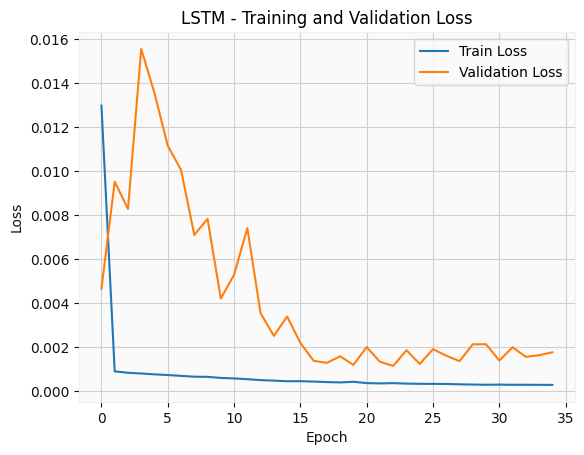

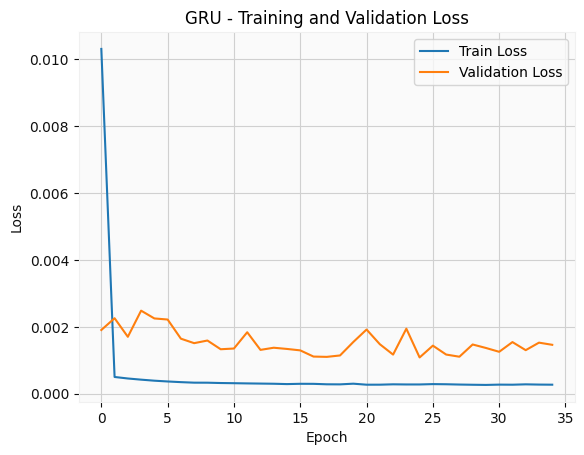

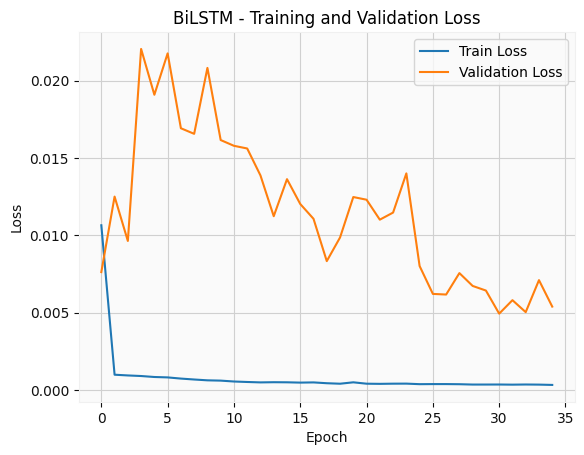

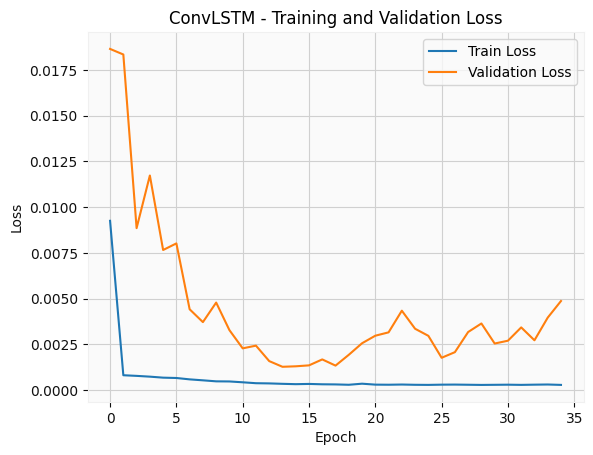

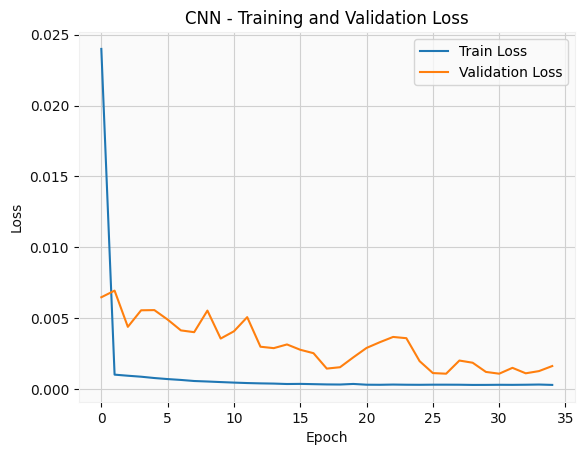

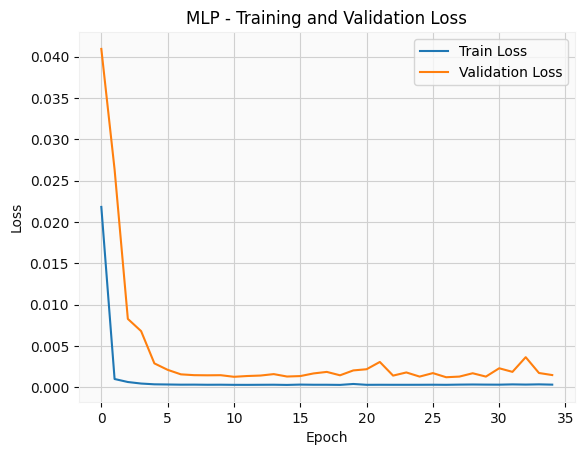

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 0.65, MSE: 0.81, MAPE: 1.34%
GRU - MAE: 0.58, MSE: 0.67, MAPE: 1.21%
BiLSTM - MAE: 1.08, MSE: 2.48, MAPE: 2.13%
ConvLSTM - MAE: 1.06, MSE: 2.24, MAPE: 2.11%
CNN - MAE: 0.64, MSE: 0.74, MAPE: 1.35%
MLP - MAE: 0.58, MSE: 0.68, MAPE: 1.22%
Naive Prediction - MAE: 0.45, MSE: 0.93, MAPE: 1.02%
cross validation length is 1173
(5216, 1) (5216, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


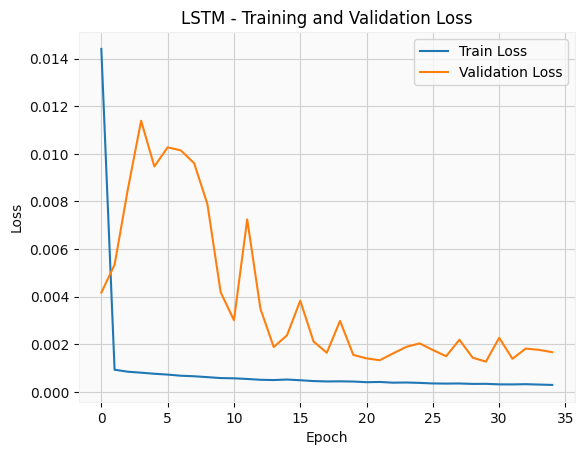

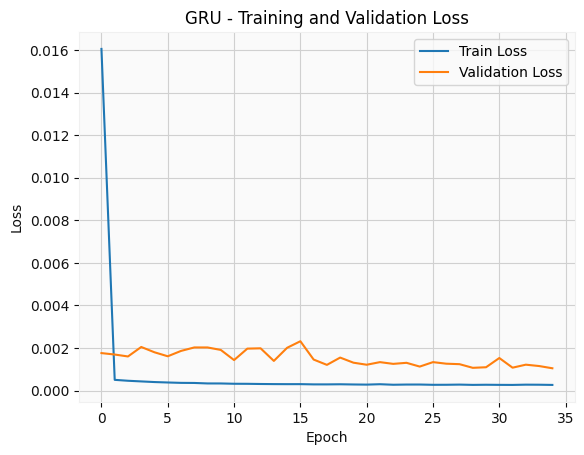

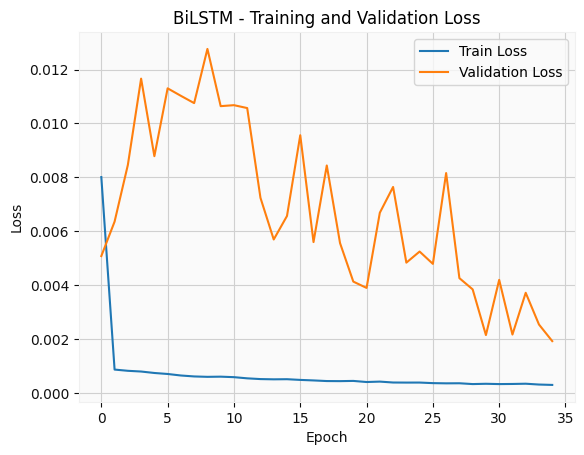

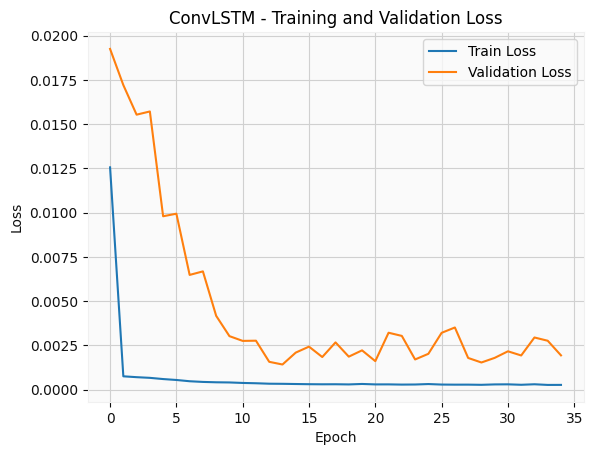

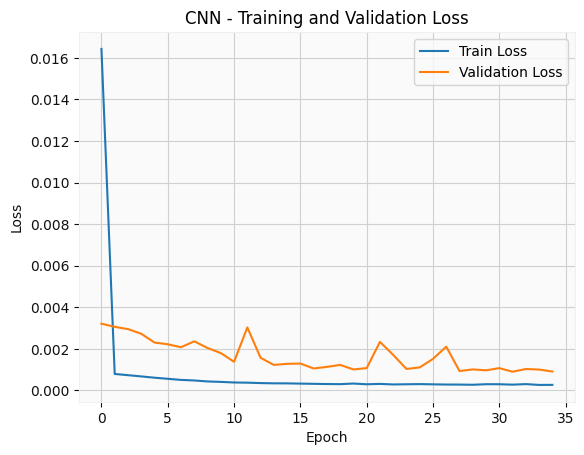

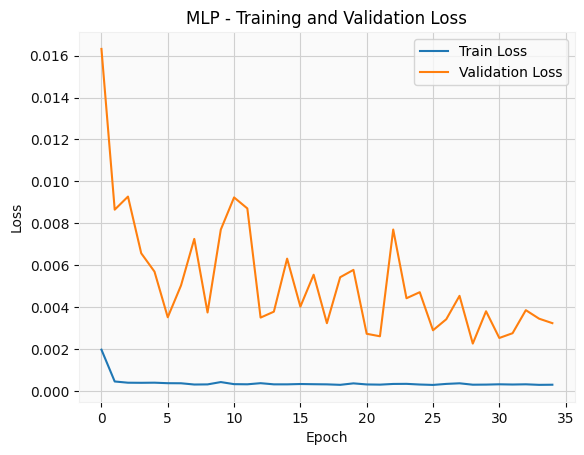

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 0.61, MSE: 0.77, MAPE: 1.27%
GRU - MAE: 0.49, MSE: 0.48, MAPE: 1.05%
BiLSTM - MAE: 0.66, MSE: 0.88, MAPE: 1.35%
ConvLSTM - MAE: 0.63, MSE: 0.89, MAPE: 1.30%
CNN - MAE: 0.45, MSE: 0.42, MAPE: 1.02%
MLP - MAE: 0.84, MSE: 1.49, MAPE: 1.69%
Naive Prediction - MAE: 0.45, MSE: 0.93, MAPE: 1.02%
cross validation length is 1173
(5216, 1) (5216, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


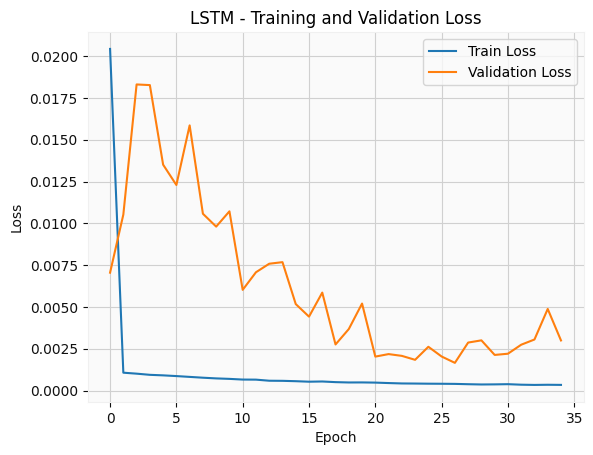

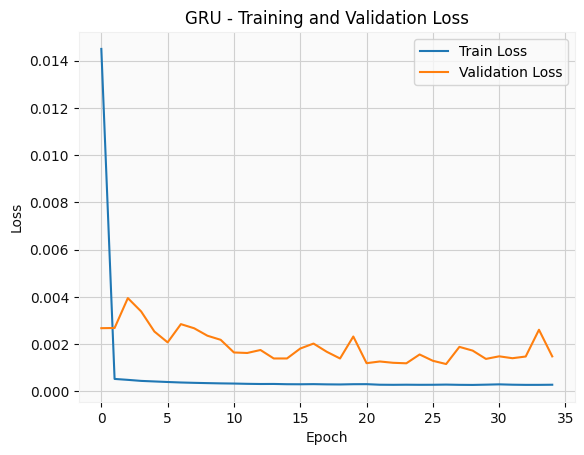

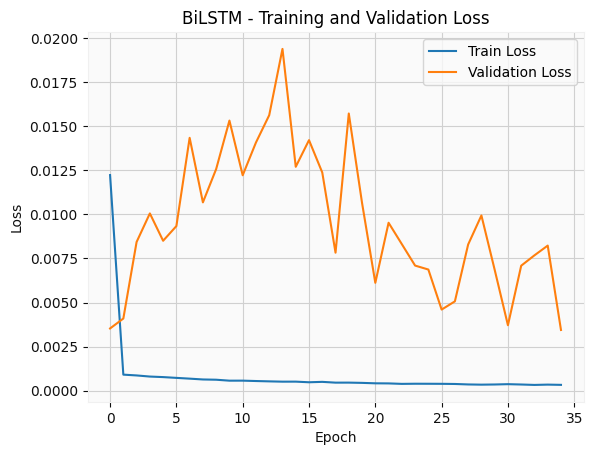

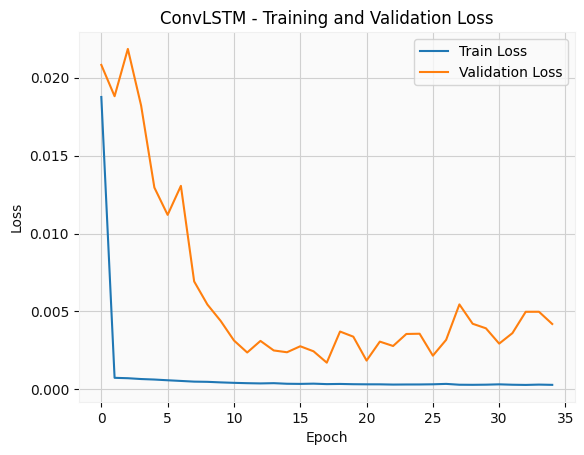

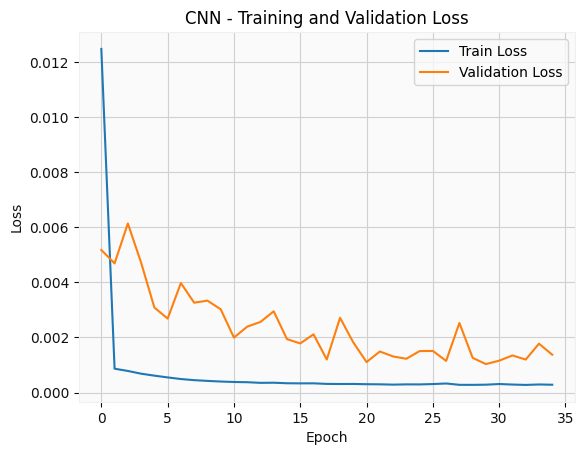

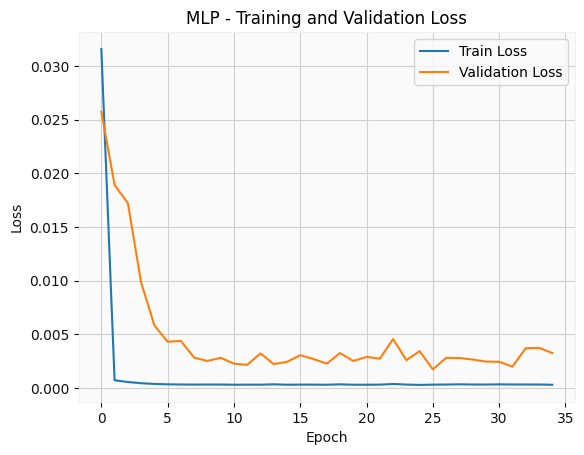

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 0.83, MSE: 1.38, MAPE: 1.67%
GRU - MAE: 0.58, MSE: 0.68, MAPE: 1.20%
BiLSTM - MAE: 0.85, MSE: 1.58, MAPE: 1.70%
ConvLSTM - MAE: 0.93, MSE: 1.93, MAPE: 1.84%
CNN - MAE: 0.59, MSE: 0.63, MAPE: 1.25%
MLP - MAE: 0.88, MSE: 1.49, MAPE: 1.78%
Naive Prediction - MAE: 0.45, MSE: 0.93, MAPE: 1.02%
cross validation length is 1173
(5216, 1) (5216, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


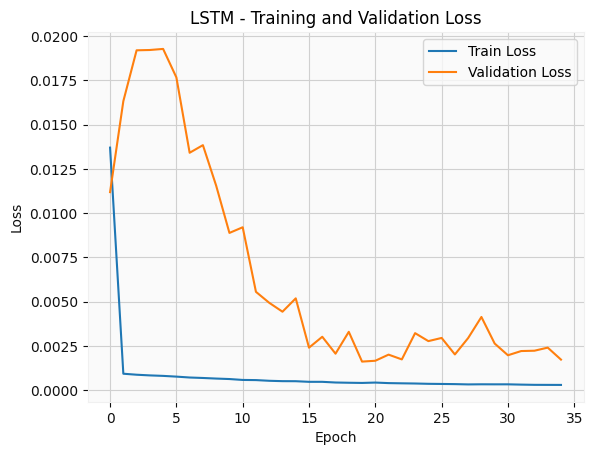

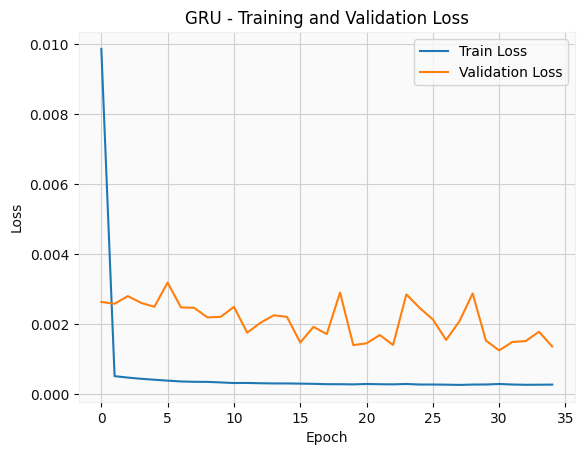

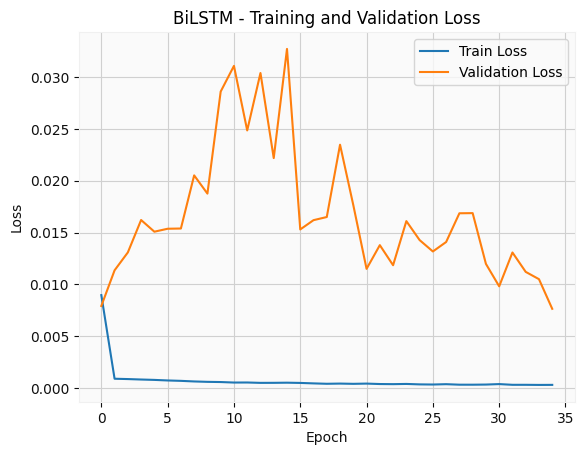

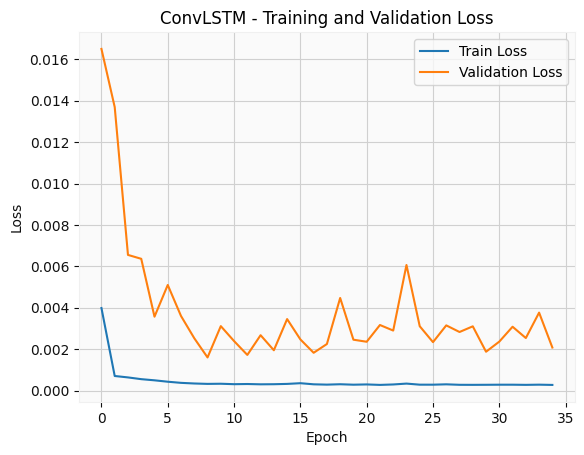

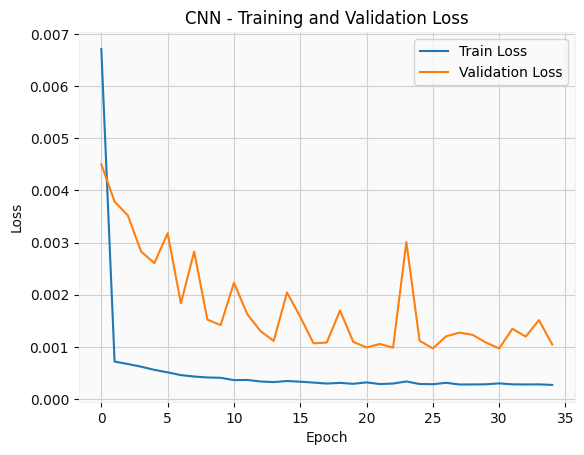

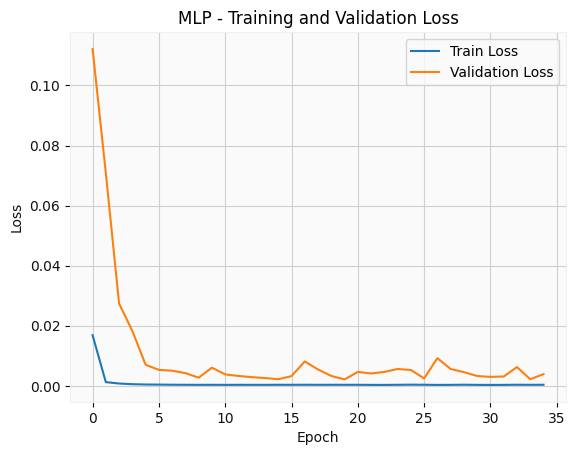

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 0.61, MSE: 0.79, MAPE: 1.27%
GRU - MAE: 0.55, MSE: 0.63, MAPE: 1.15%
BiLSTM - MAE: 1.22, MSE: 3.52, MAPE: 2.36%
ConvLSTM - MAE: 0.66, MSE: 0.96, MAPE: 1.36%
CNN - MAE: 0.51, MSE: 0.48, MAPE: 1.14%
MLP - MAE: 0.94, MSE: 1.78, MAPE: 1.88%
Naive Prediction - MAE: 0.45, MSE: 0.93, MAPE: 1.02%
cross validation length is 1759
(8146, 1) (8146, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


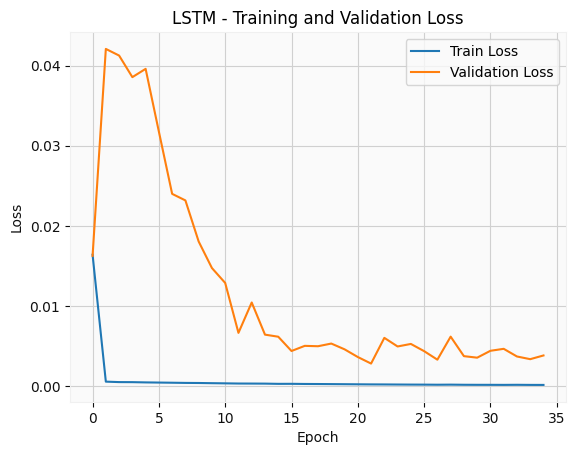

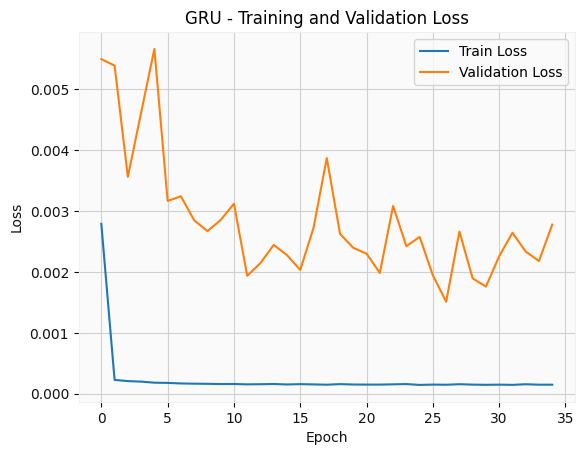

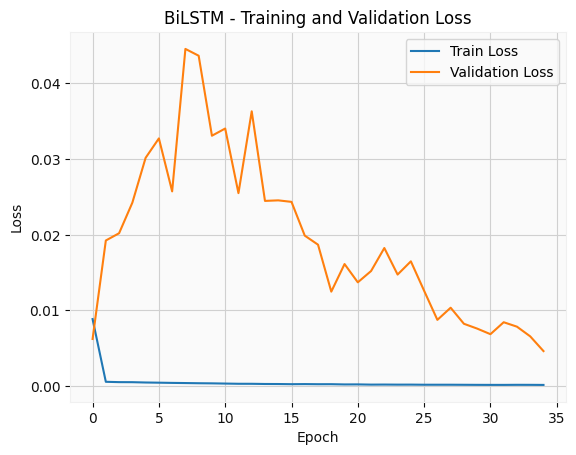

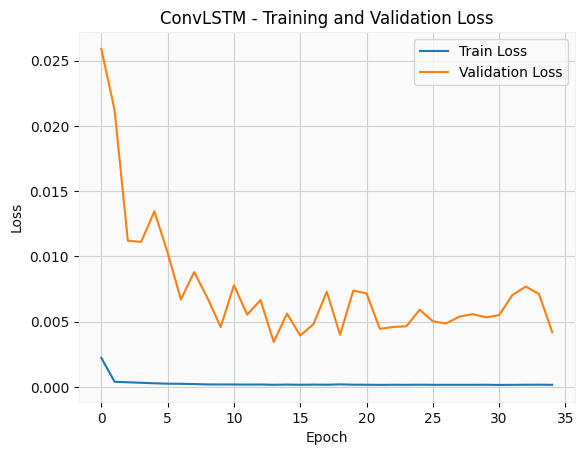

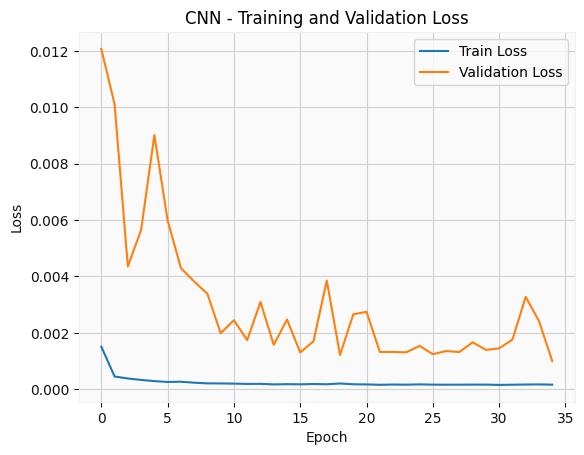

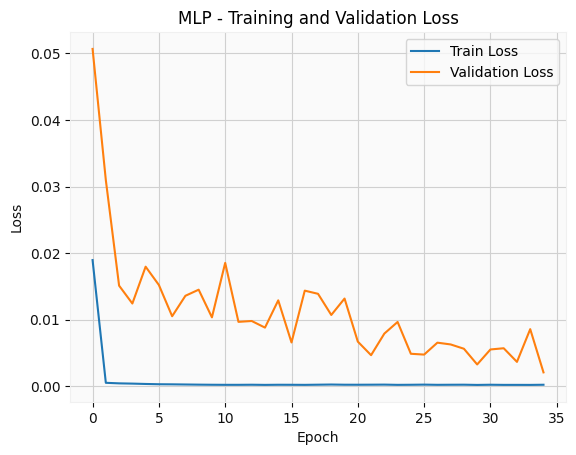

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 1.82, MSE: 6.27, MAPE: 2.11%
GRU - MAE: 1.57, MSE: 4.55, MAPE: 1.85%
BiLSTM - MAE: 1.87, MSE: 7.58, MAPE: 2.10%
ConvLSTM - MAE: 1.69, MSE: 6.86, MAPE: 1.88%
CNN - MAE: 0.88, MSE: 1.64, MAPE: 1.12%
MLP - MAE: 1.24, MSE: 3.38, MAPE: 1.44%
Naive Prediction - MAE: 0.87, MSE: 5.40, MAPE: 1.13%
cross validation length is 1759
(8146, 1) (8146, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


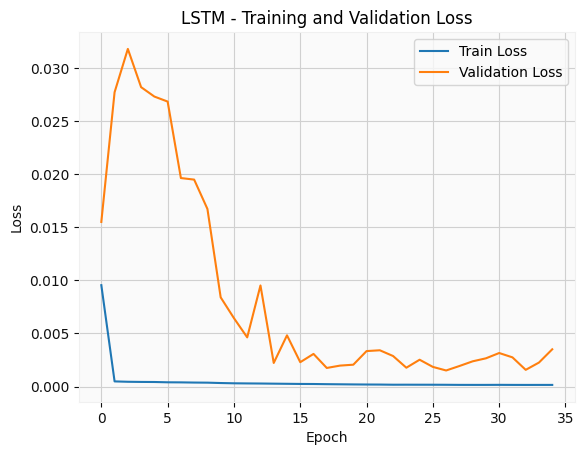

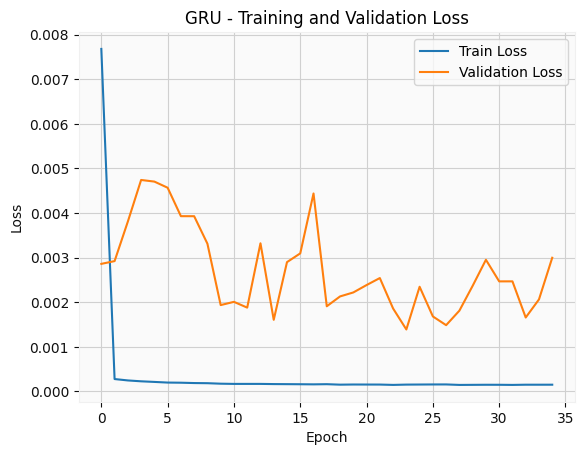

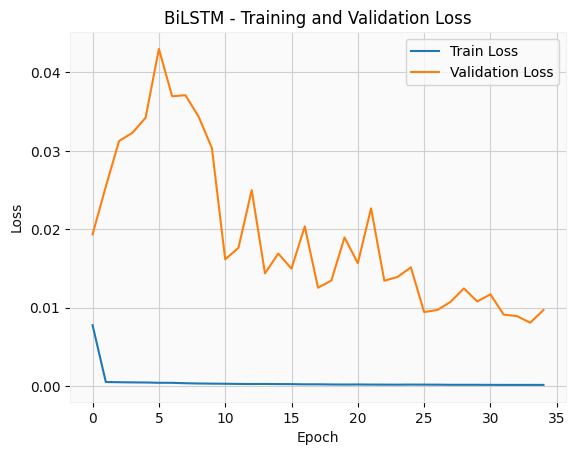

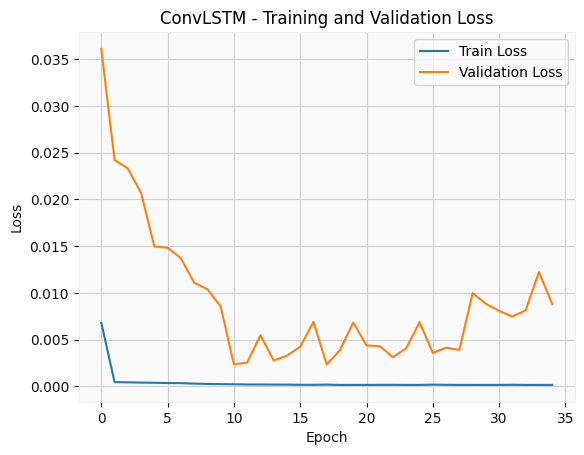

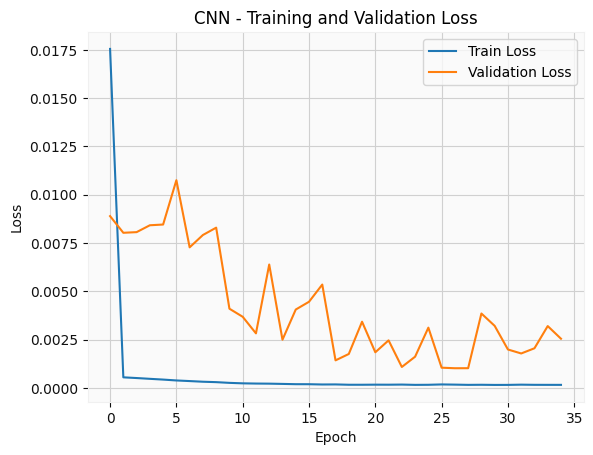

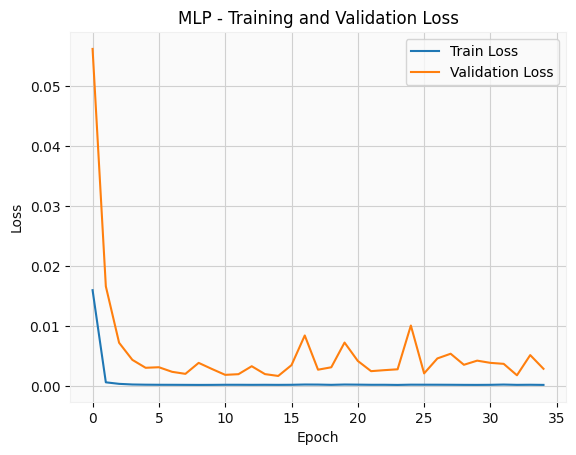

90/90 [==============================] - 0s 3ms/step
LSTM - MAE: 1.82, MSE: 5.74, MAPE: 2.16%
GRU - MAE: 1.62, MSE: 4.91, MAPE: 1.90%
BiLSTM - MAE: 3.01, MSE: 15.91, MAPE: 3.48%
ConvLSTM - MAE: 2.77, MSE: 14.42, MAPE: 3.17%
CNN - MAE: 1.64, MSE: 4.18, MAPE: 2.01%
MLP - MAE: 1.50, MSE: 4.69, MAPE: 1.72%
Naive Prediction - MAE: 0.87, MSE: 5.40, MAPE: 1.13%
cross validation length is 1759
(8146, 1) (8146, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


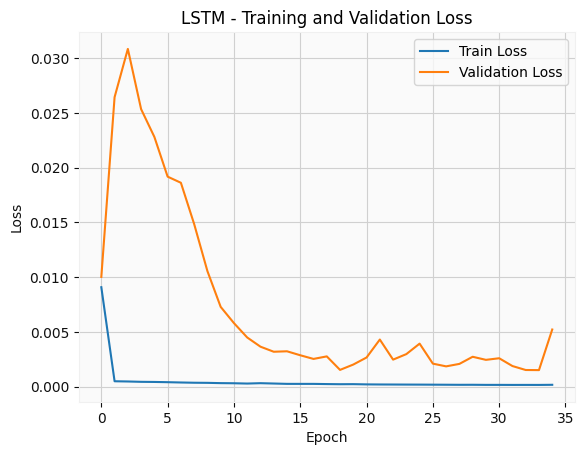

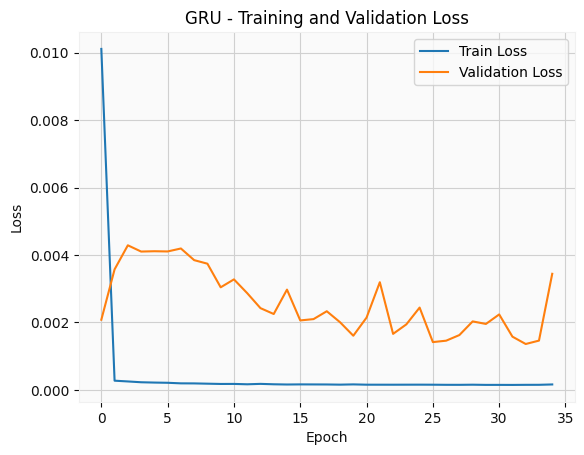

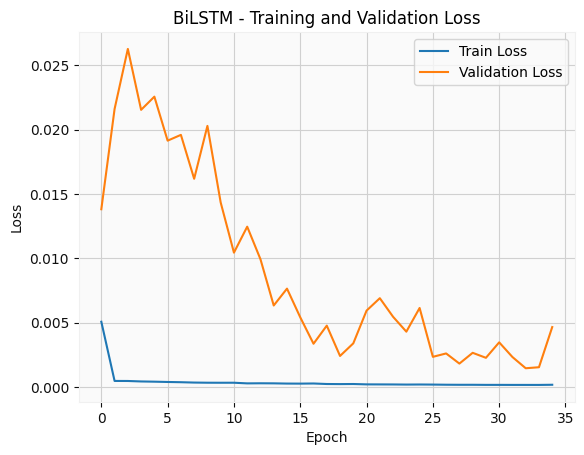

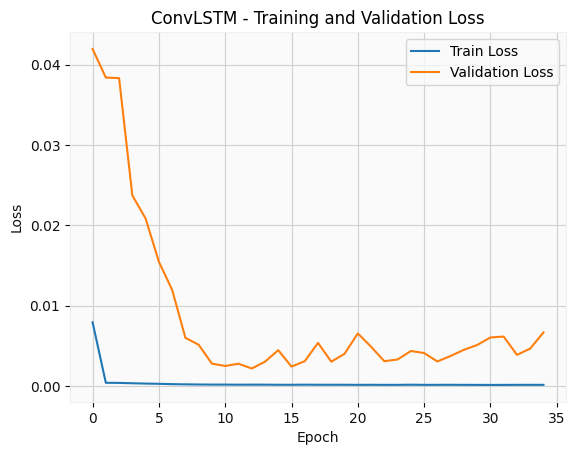

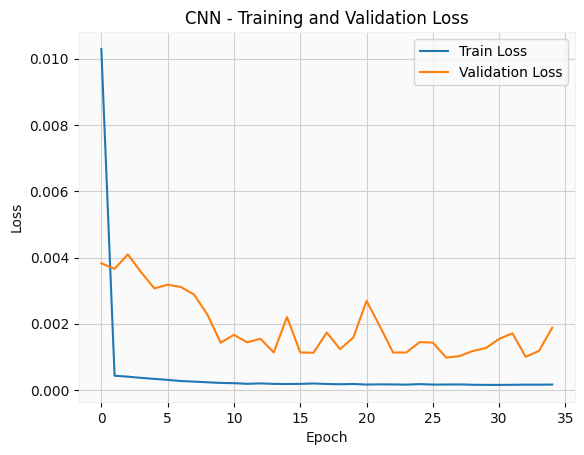

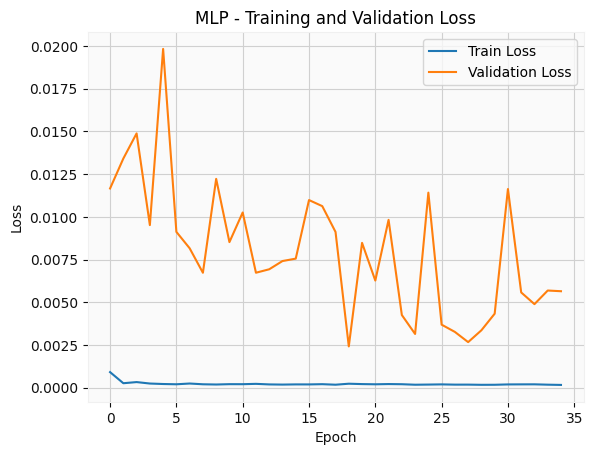

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 2.44, MSE: 8.54, MAPE: 2.97%
GRU - MAE: 1.89, MSE: 5.64, MAPE: 2.28%
BiLSTM - MAE: 2.21, MSE: 7.63, MAPE: 2.66%
ConvLSTM - MAE: 2.43, MSE: 10.95, MAPE: 2.79%
CNN - MAE: 1.37, MSE: 3.08, MAPE: 1.67%
MLP - MAE: 2.39, MSE: 9.25, MAPE: 2.82%
Naive Prediction - MAE: 0.87, MSE: 5.40, MAPE: 1.13%
cross validation length is 1759
(8146, 1) (8146, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


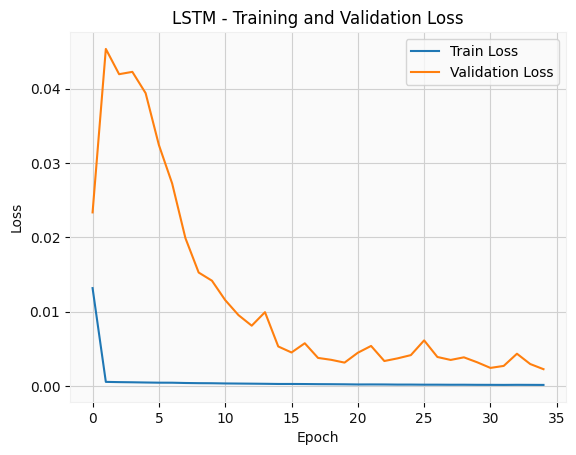

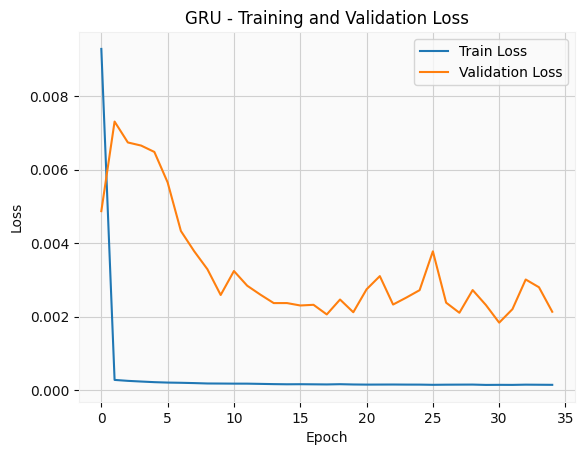

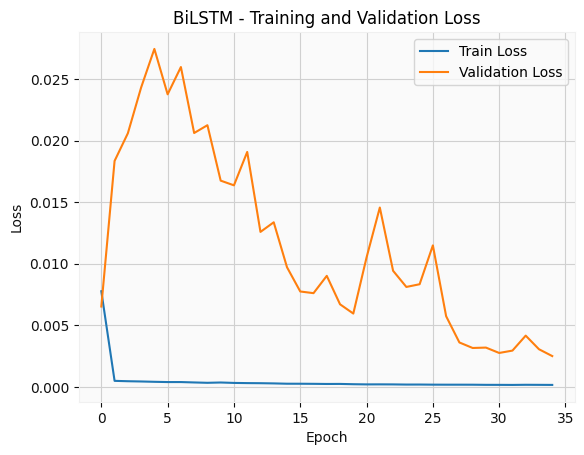

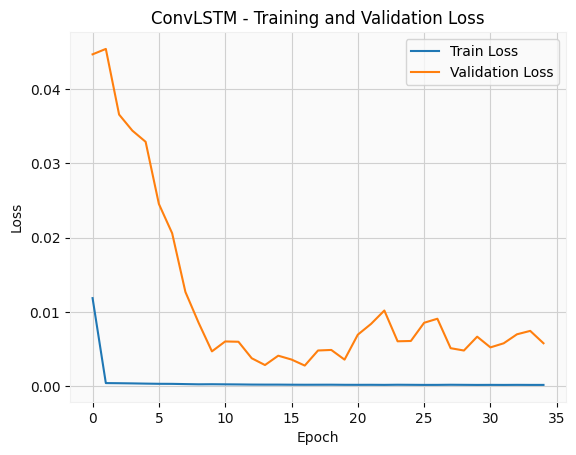

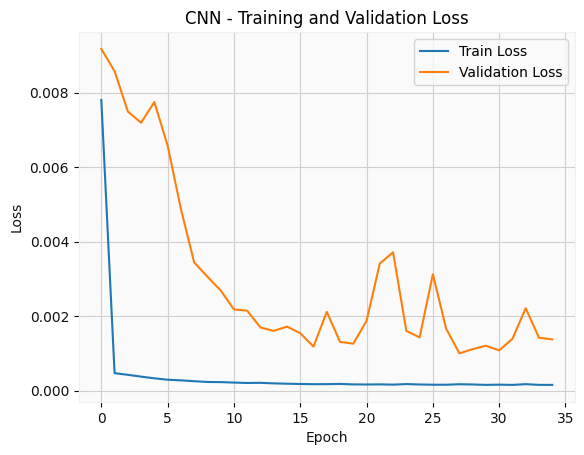

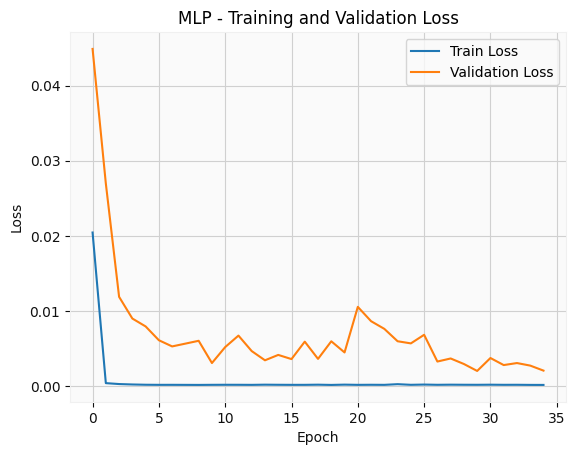

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 1.31, MSE: 3.73, MAPE: 1.51%
GRU - MAE: 1.26, MSE: 3.50, MAPE: 1.46%
BiLSTM - MAE: 1.39, MSE: 4.09, MAPE: 1.61%
ConvLSTM - MAE: 2.07, MSE: 9.46, MAPE: 2.32%
CNN - MAE: 1.09, MSE: 2.25, MAPE: 1.32%
MLP - MAE: 1.22, MSE: 3.39, MAPE: 1.42%
Naive Prediction - MAE: 0.87, MSE: 5.40, MAPE: 1.13%
cross validation length is 1759
(8146, 1) (8146, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


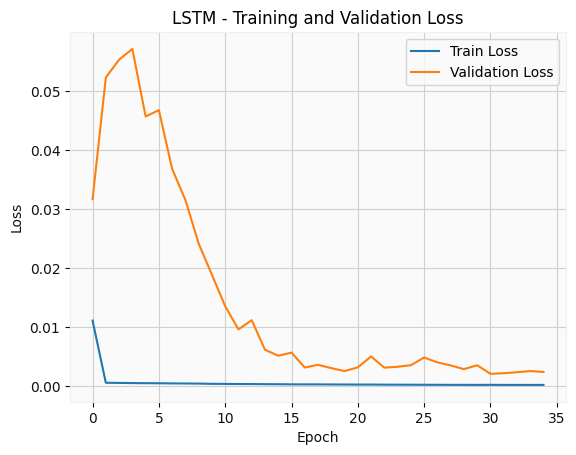

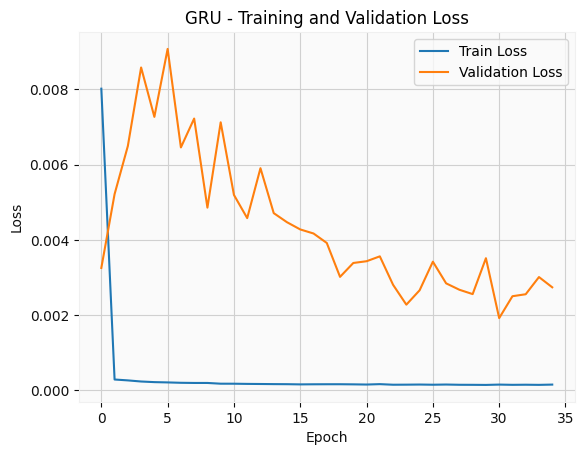

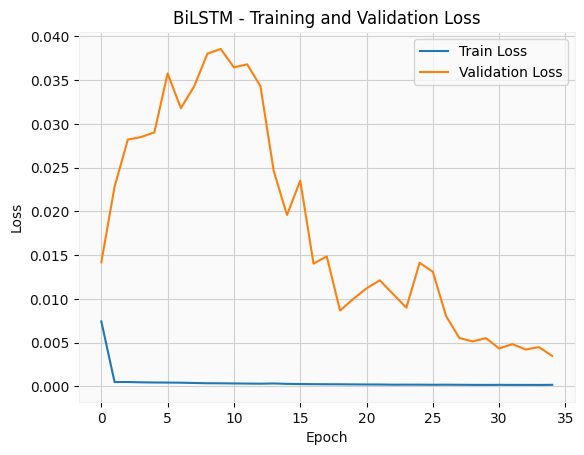

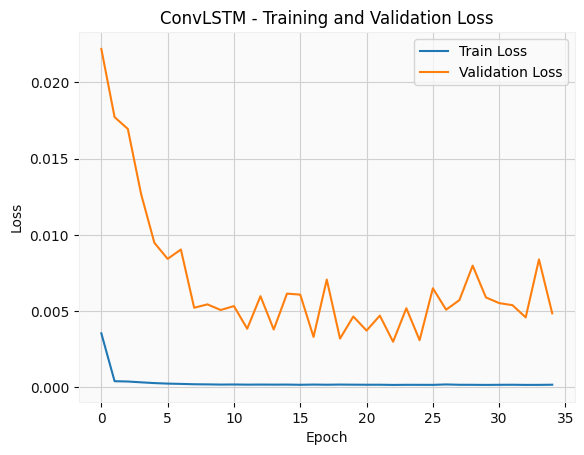

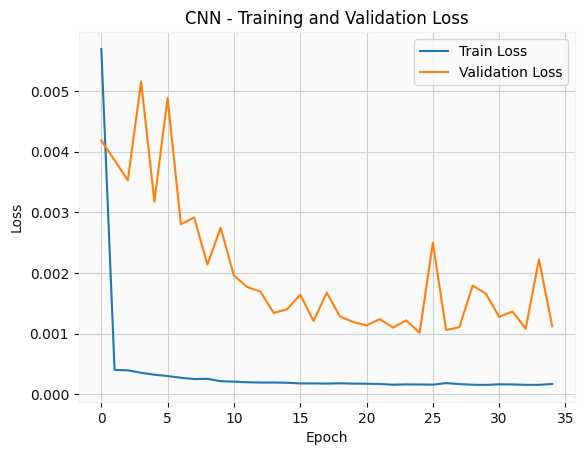

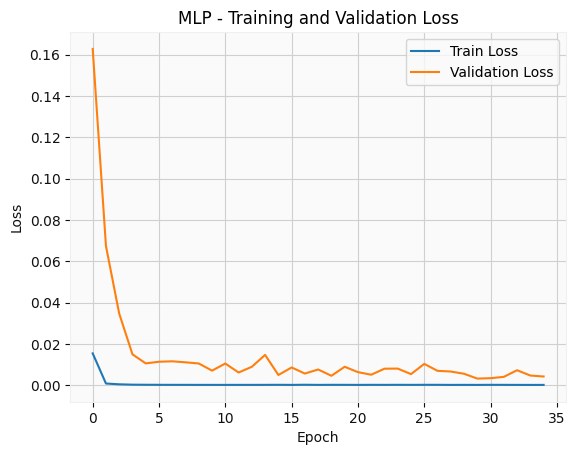

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 1.36, MSE: 3.84, MAPE: 1.57%
GRU - MAE: 1.46, MSE: 4.49, MAPE: 1.68%
BiLSTM - MAE: 1.65, MSE: 5.68, MAPE: 1.89%
ConvLSTM - MAE: 1.85, MSE: 7.95, MAPE: 2.06%
CNN - MAE: 0.92, MSE: 1.84, MAPE: 1.12%
MLP - MAE: 1.83, MSE: 6.95, MAPE: 2.08%
Naive Prediction - MAE: 0.87, MSE: 5.40, MAPE: 1.13%
cross validation length is 2345
(11076, 1) (11076, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


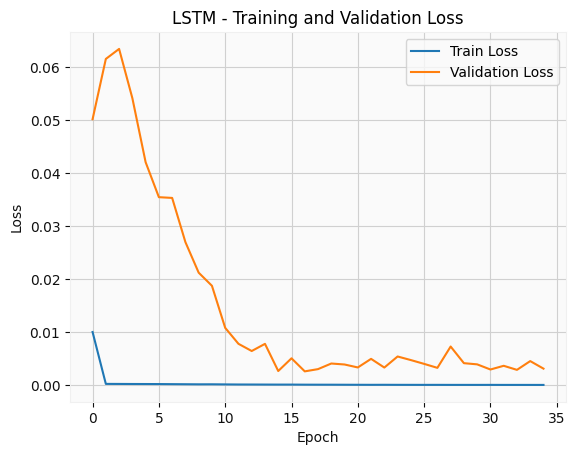

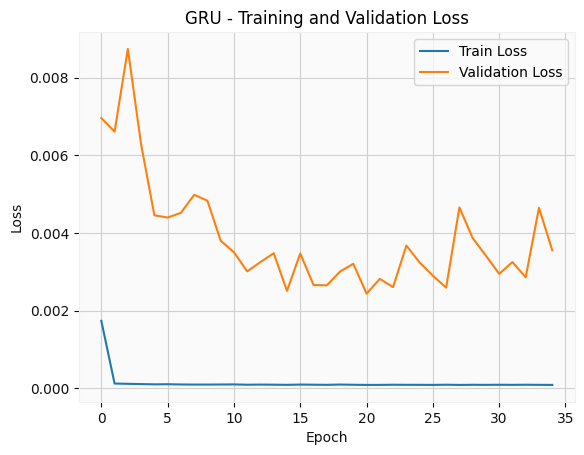

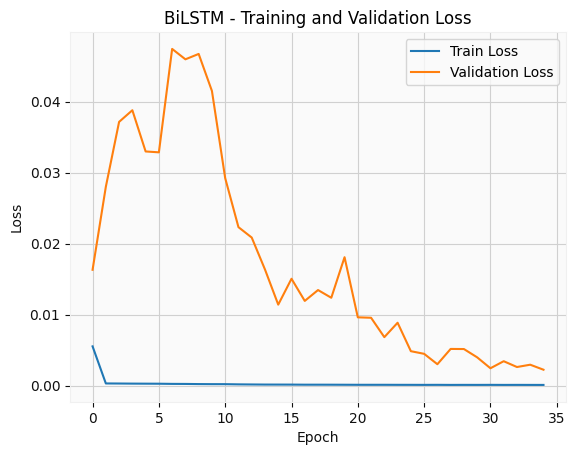

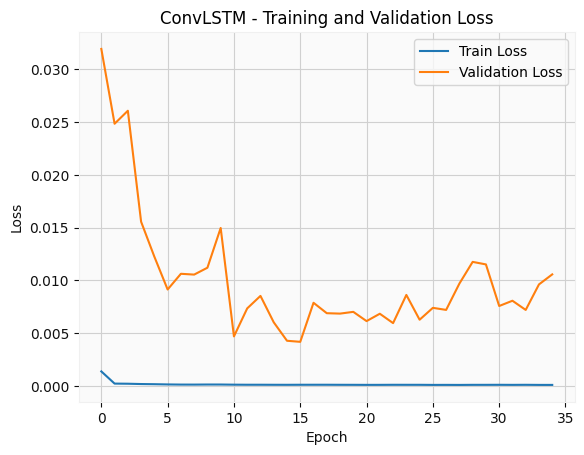

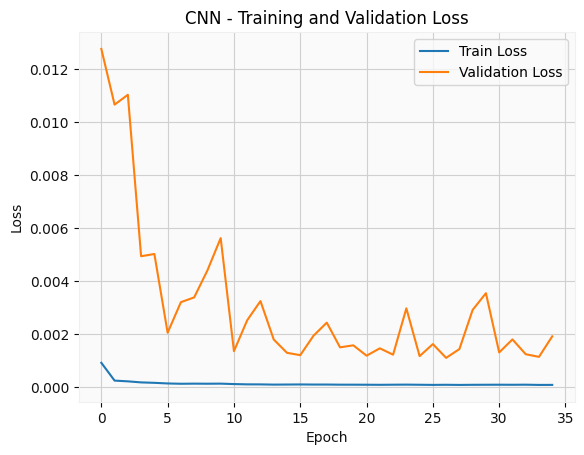

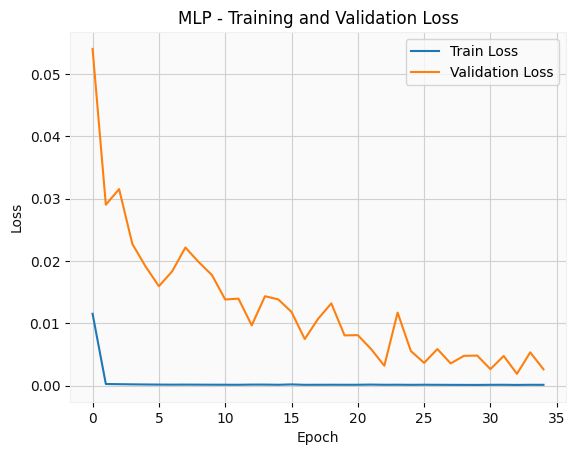

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 3.97, MSE: 35.64, MAPE: 2.06%
GRU - MAE: 4.16, MSE: 40.10, MAPE: 2.14%
BiLSTM - MAE: 3.39, MSE: 25.17, MAPE: 1.84%
ConvLSTM - MAE: 7.34, MSE: 119.28, MAPE: 3.60%
CNN - MAE: 3.43, MSE: 21.67, MAPE: 1.92%
MLP - MAE: 3.72, MSE: 29.46, MAPE: 1.97%
Naive Prediction - MAE: 2.57, MSE: 54.58, MAPE: 1.64%
cross validation length is 2345
(11076, 1) (11076, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


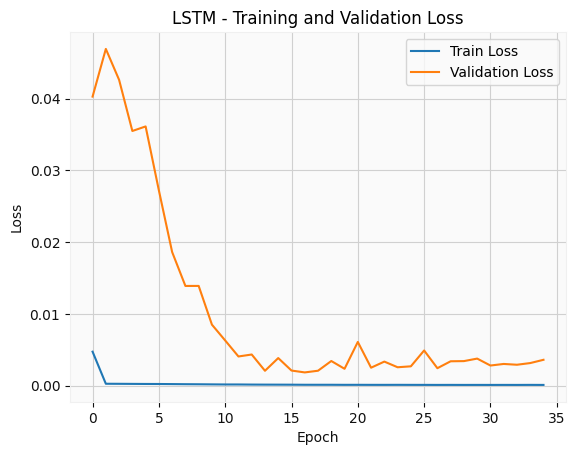

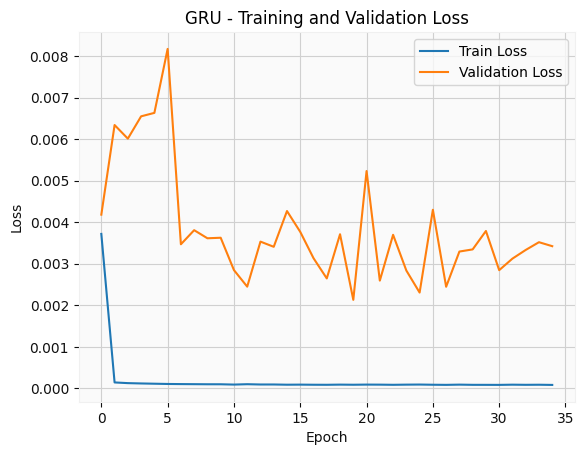

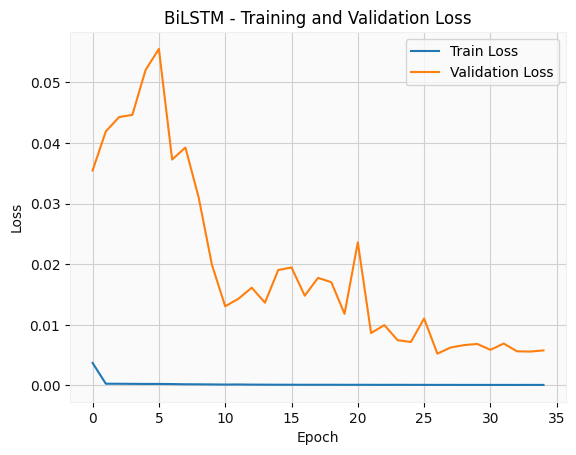

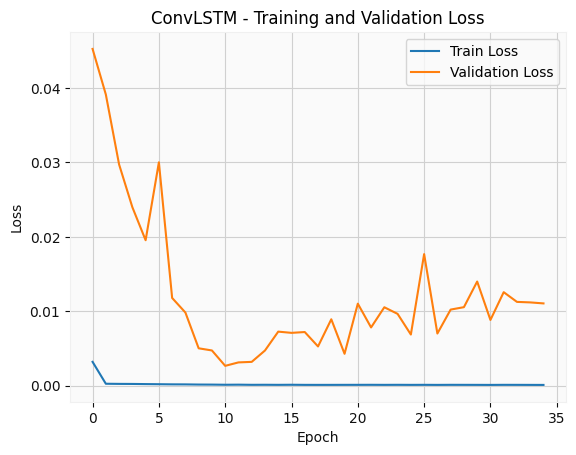

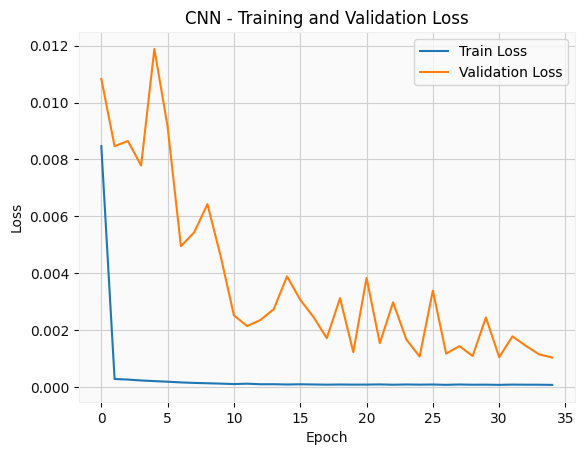

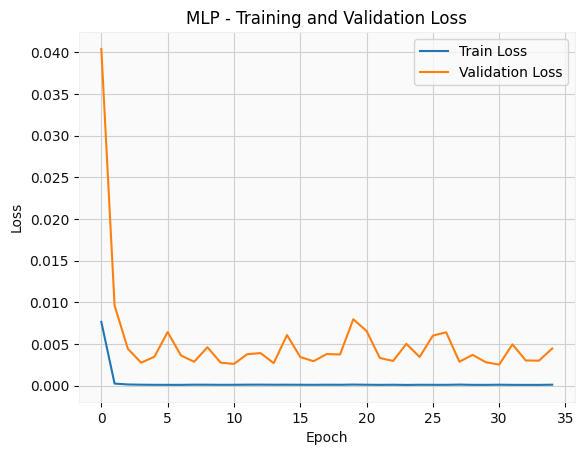

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.37, MSE: 40.51, MAPE: 2.27%
GRU - MAE: 4.11, MSE: 38.64, MAPE: 2.12%
BiLSTM - MAE: 5.16, MSE: 65.26, MAPE: 2.55%
ConvLSTM - MAE: 6.94, MSE: 124.73, MAPE: 3.30%
CNN - MAE: 2.37, MSE: 11.83, MAPE: 1.43%
MLP - MAE: 4.97, MSE: 50.45, MAPE: 2.57%
Naive Prediction - MAE: 2.57, MSE: 54.58, MAPE: 1.64%
cross validation length is 2345
(11076, 1) (11076, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


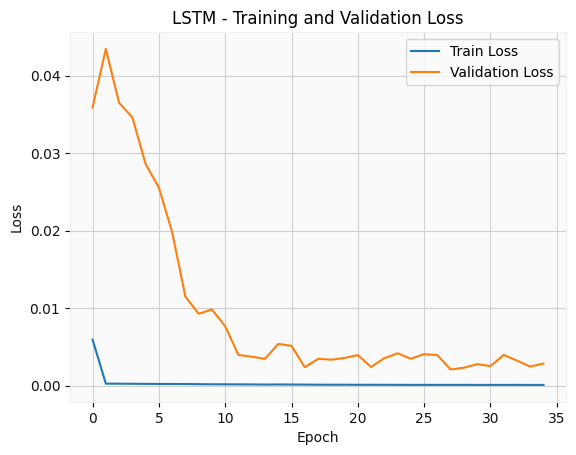

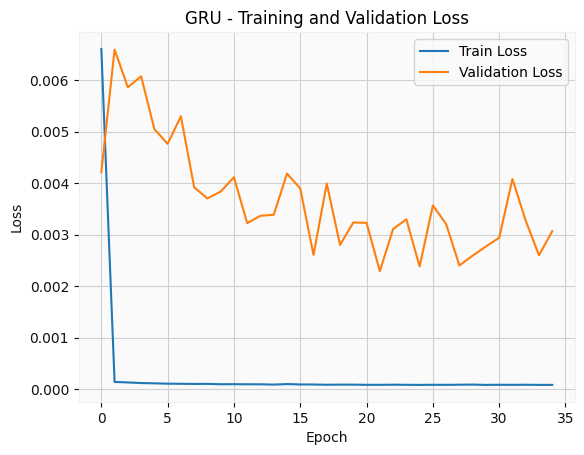

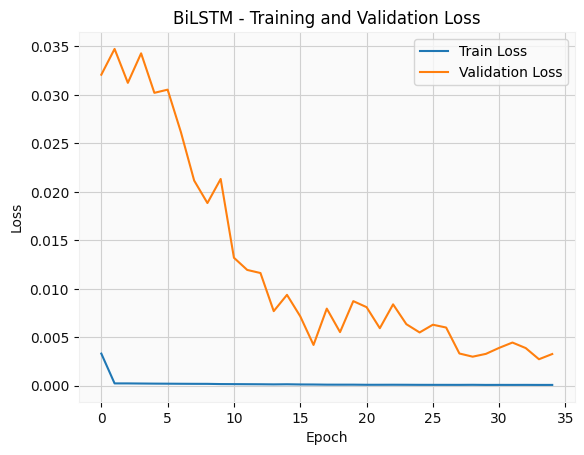

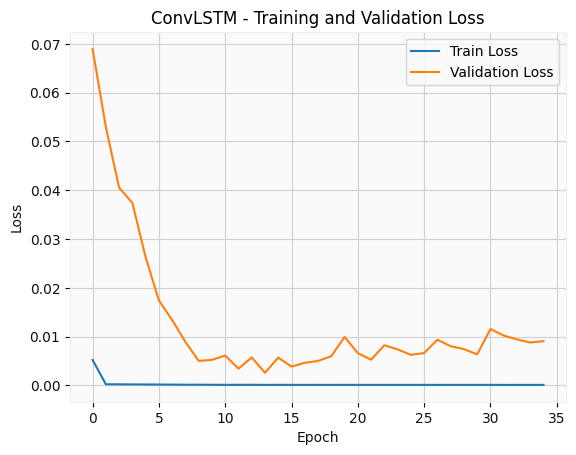

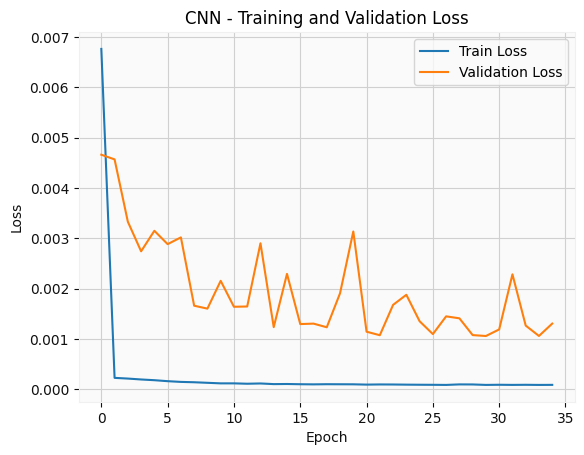

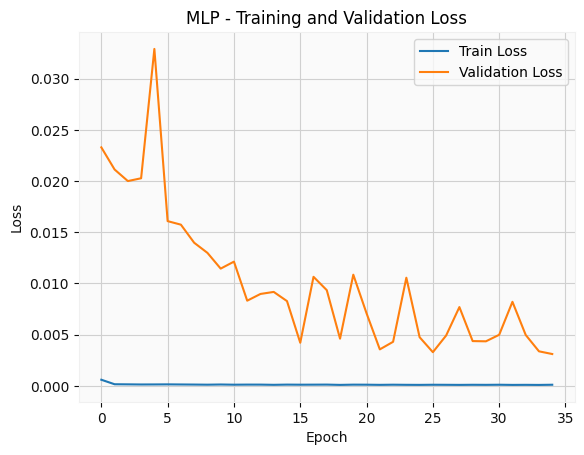

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 3.83, MSE: 32.03, MAPE: 2.01%
GRU - MAE: 3.92, MSE: 34.64, MAPE: 2.04%
BiLSTM - MAE: 4.04, MSE: 36.97, MAPE: 2.09%
ConvLSTM - MAE: 6.44, MSE: 102.39, MAPE: 3.10%
CNN - MAE: 2.73, MSE: 14.75, MAPE: 1.58%
MLP - MAE: 4.04, MSE: 35.14, MAPE: 2.11%
Naive Prediction - MAE: 2.57, MSE: 54.58, MAPE: 1.64%
cross validation length is 2345
(11076, 1) (11076, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


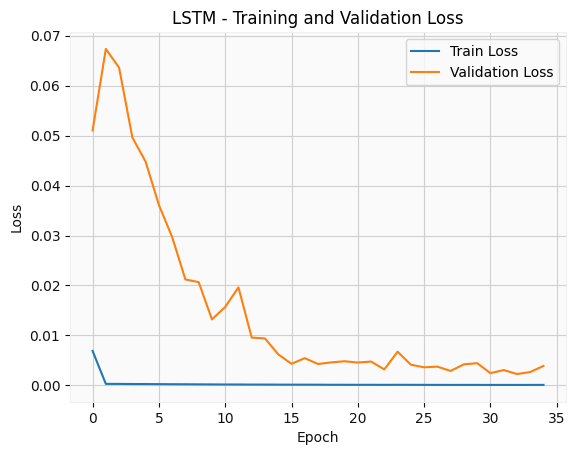

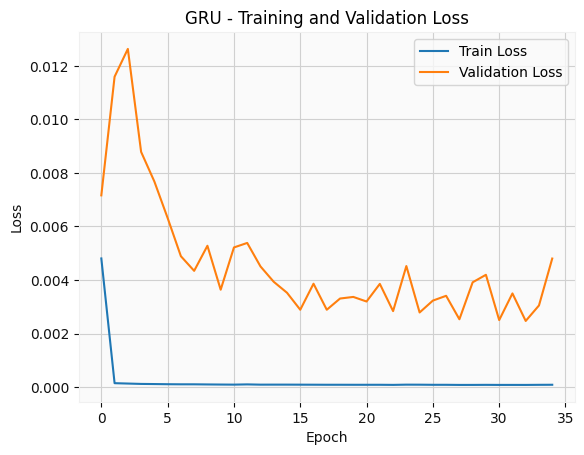

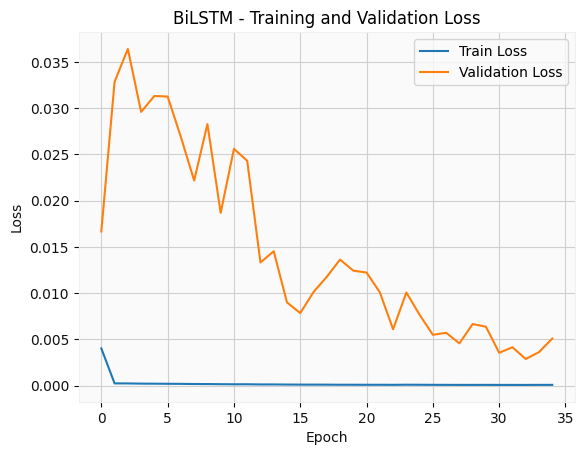

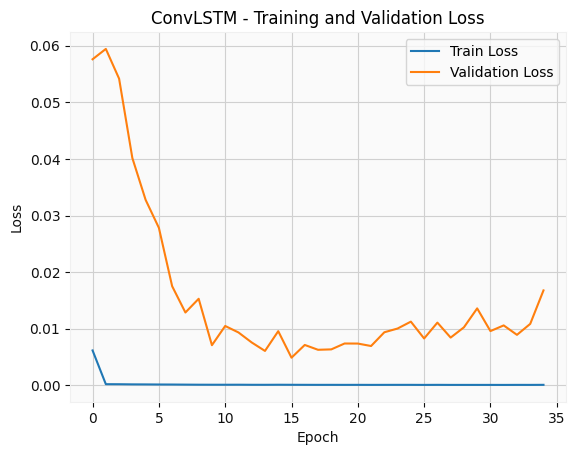

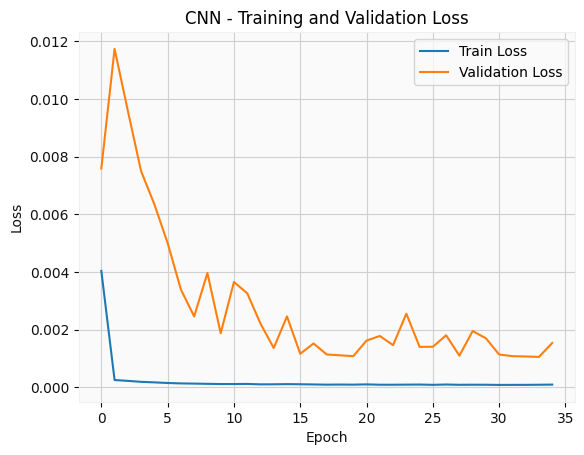

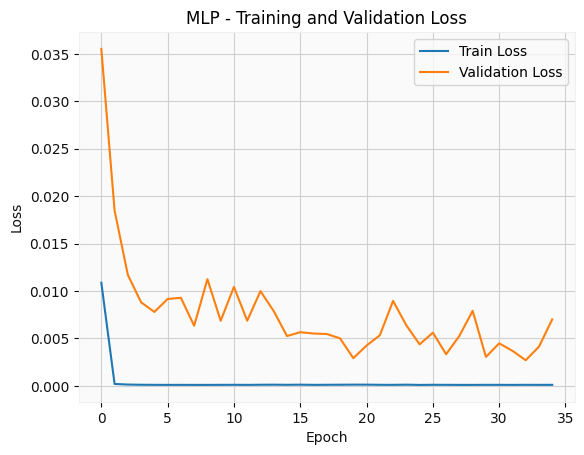

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.48, MSE: 43.92, MAPE: 2.30%
GRU - MAE: 5.05, MSE: 54.23, MAPE: 2.58%
BiLSTM - MAE: 5.09, MSE: 57.50, MAPE: 2.57%
ConvLSTM - MAE: 9.21, MSE: 189.41, MAPE: 4.45%
CNN - MAE: 3.03, MSE: 17.40, MAPE: 1.73%
MLP - MAE: 6.44, MSE: 79.18, MAPE: 3.30%
Naive Prediction - MAE: 2.57, MSE: 54.58, MAPE: 1.64%
cross validation length is 2345
(11076, 1) (11076, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


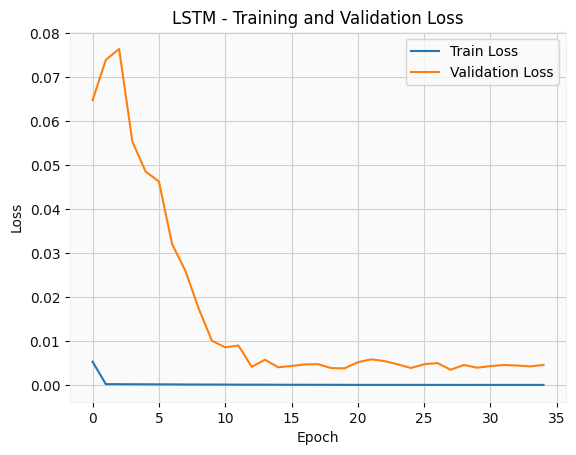

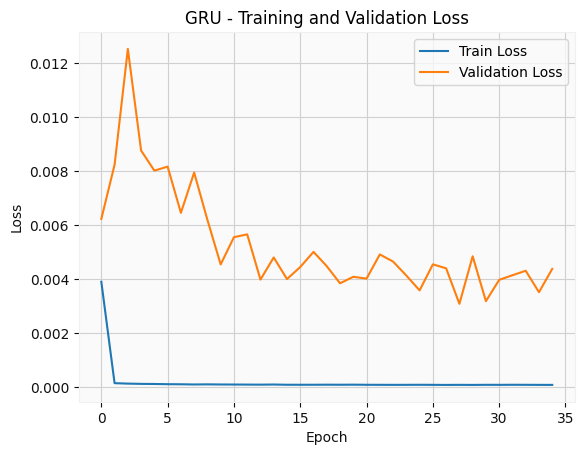

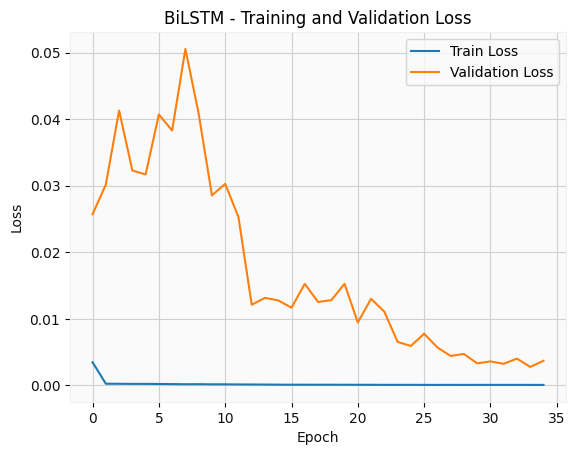

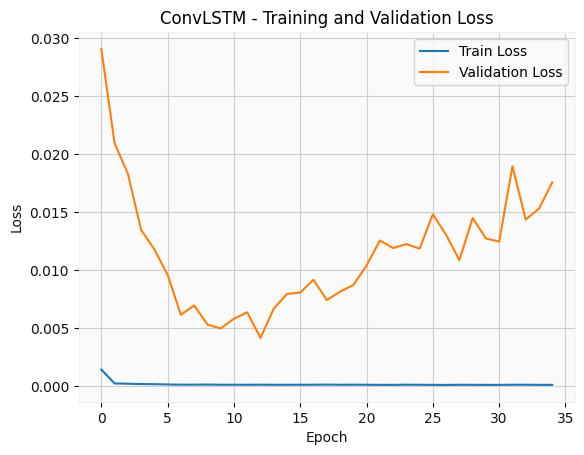

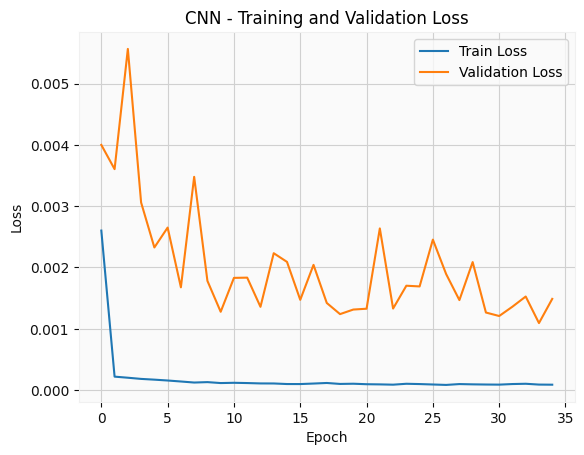

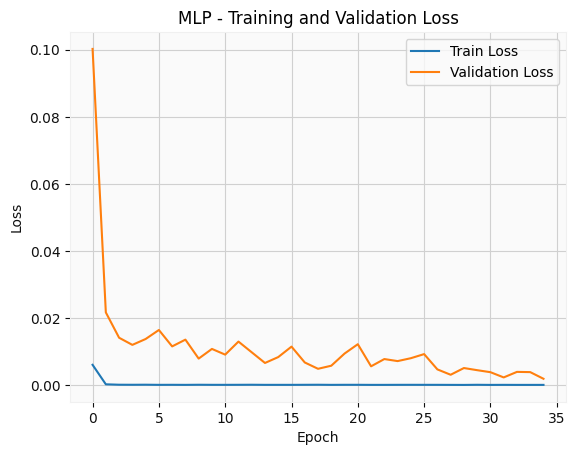

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.84, MSE: 52.28, MAPE: 2.45%
GRU - MAE: 4.64, MSE: 49.48, MAPE: 2.35%
BiLSTM - MAE: 4.41, MSE: 41.87, MAPE: 2.30%
ConvLSTM - MAE: 8.94, MSE: 198.00, MAPE: 4.21%
CNN - MAE: 2.95, MSE: 16.80, MAPE: 1.68%
MLP - MAE: 3.19, MSE: 21.76, MAPE: 1.76%
Naive Prediction - MAE: 2.57, MSE: 54.58, MAPE: 1.64%
cross validation length is 2931
(14006, 1) (14006, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


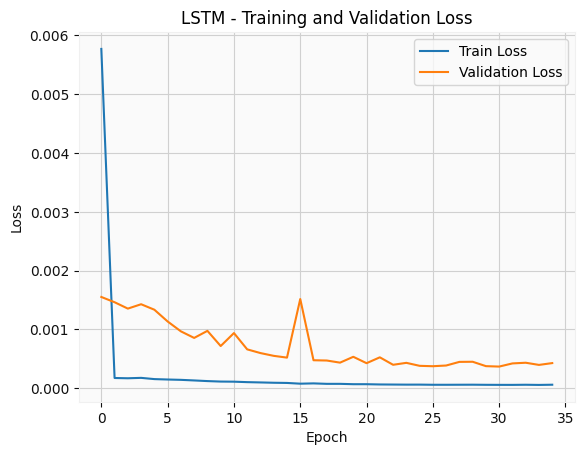

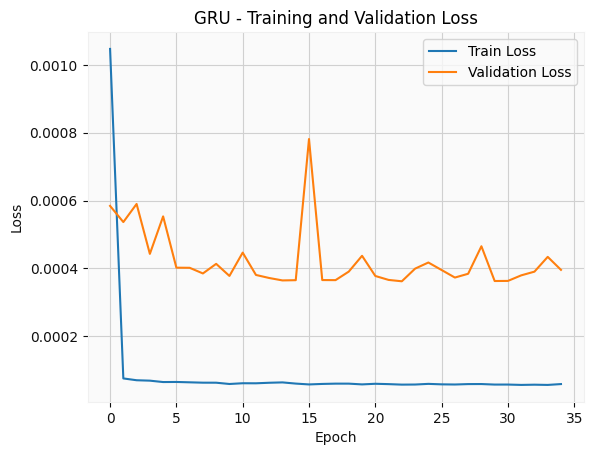

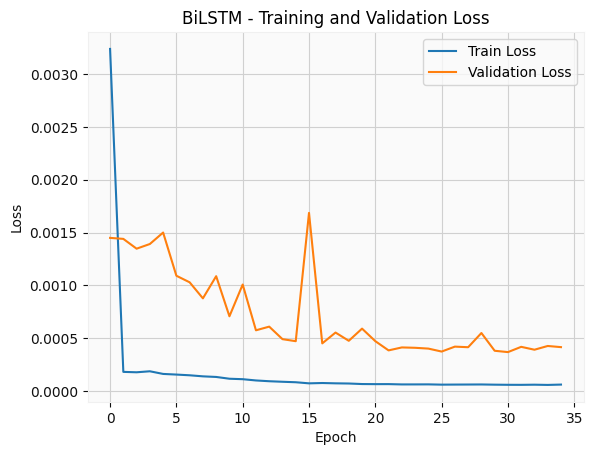

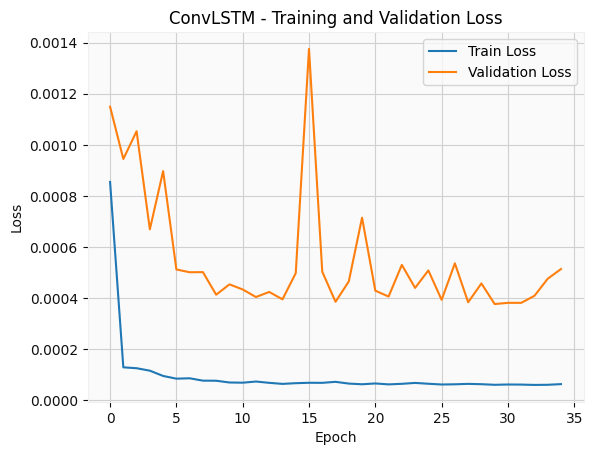

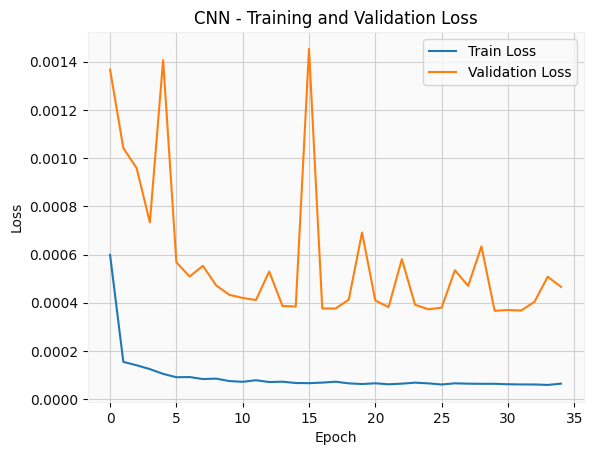

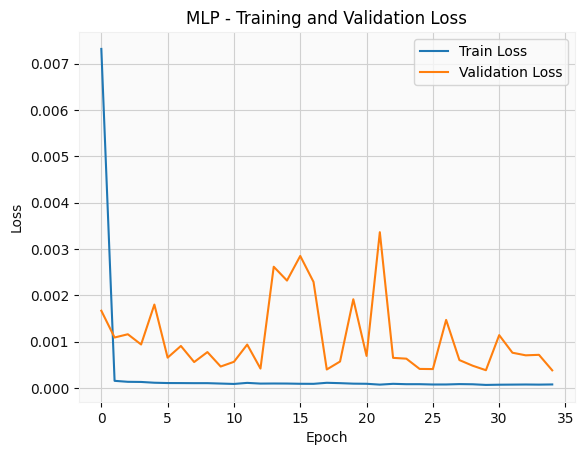

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.39, MSE: 33.69, MAPE: 1.81%
GRU - MAE: 4.18, MSE: 31.22, MAPE: 1.74%
BiLSTM - MAE: 4.31, MSE: 32.72, MAPE: 1.79%
ConvLSTM - MAE: 4.93, MSE: 40.59, MAPE: 1.99%
CNN - MAE: 4.68, MSE: 36.80, MAPE: 1.92%
MLP - MAE: 4.11, MSE: 30.01, MAPE: 1.73%
Naive Prediction - MAE: 3.97, MSE: 35.24, MAPE: 1.67%
cross validation length is 2931
(14006, 1) (14006, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


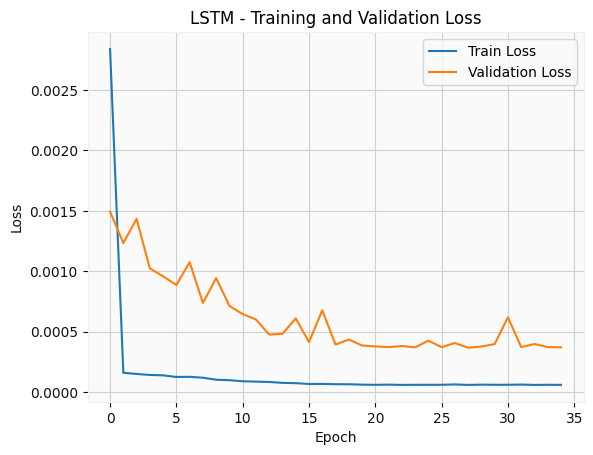

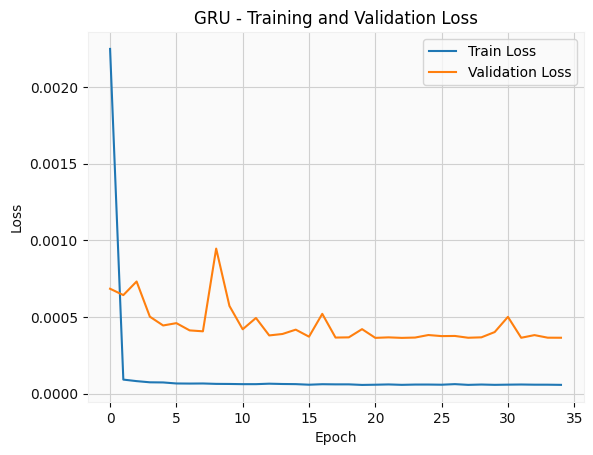

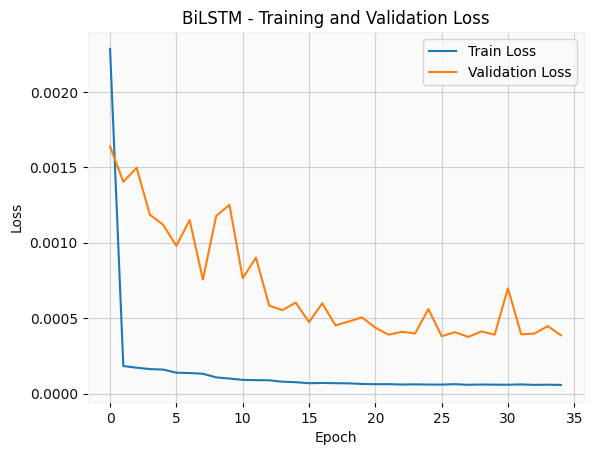

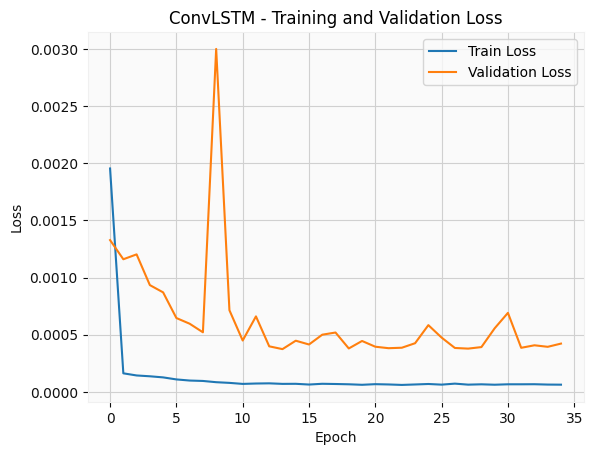

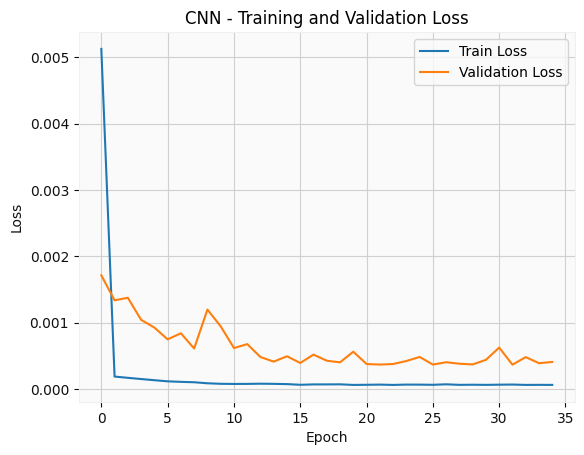

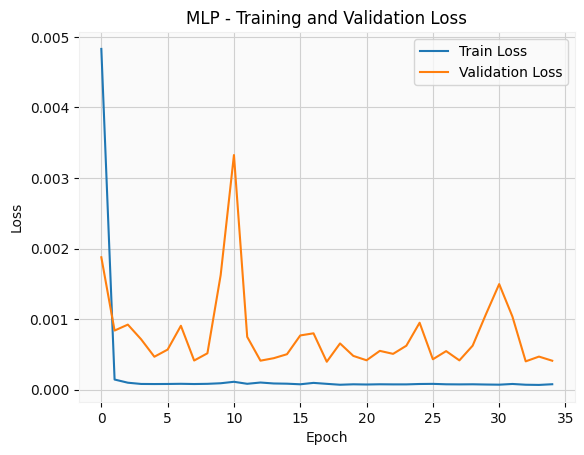

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 3.96, MSE: 29.11, MAPE: 1.67%
GRU - MAE: 3.94, MSE: 28.76, MAPE: 1.66%
BiLSTM - MAE: 4.10, MSE: 30.50, MAPE: 1.71%
ConvLSTM - MAE: 4.35, MSE: 33.32, MAPE: 1.78%
CNN - MAE: 4.30, MSE: 32.14, MAPE: 1.78%
MLP - MAE: 4.23, MSE: 32.33, MAPE: 1.80%
Naive Prediction - MAE: 3.97, MSE: 35.24, MAPE: 1.67%
cross validation length is 2931
(14006, 1) (14006, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


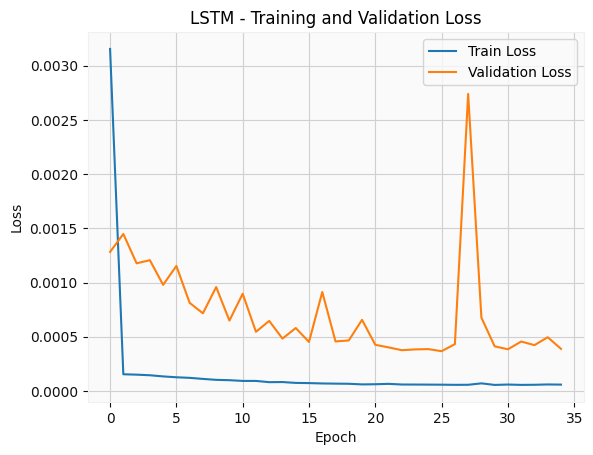

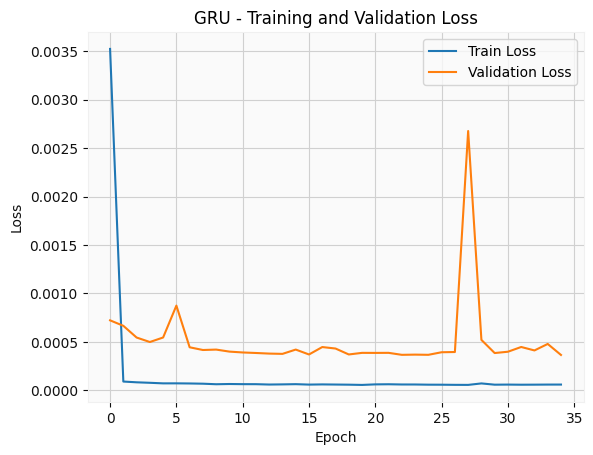

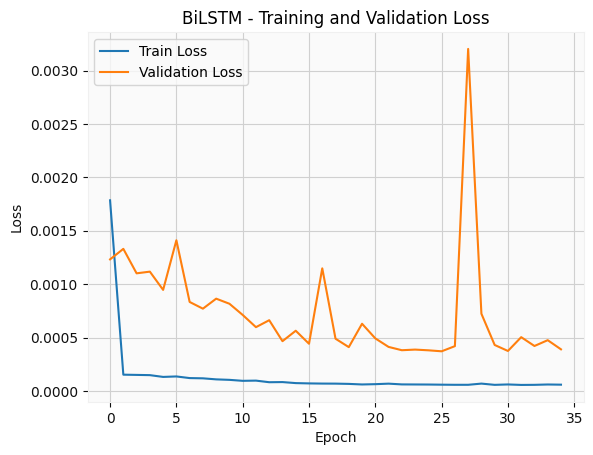

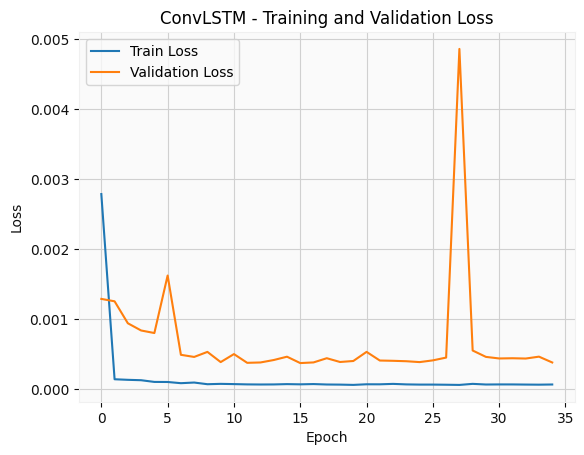

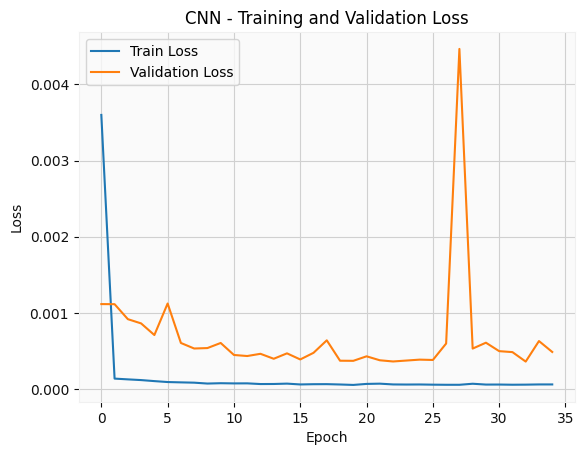

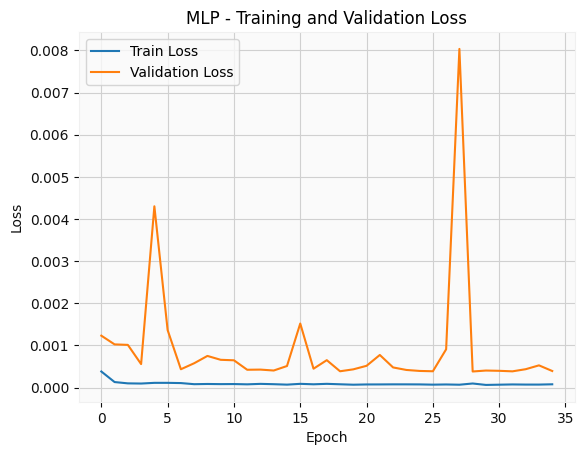

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.08, MSE: 30.70, MAPE: 1.73%
GRU - MAE: 3.94, MSE: 28.79, MAPE: 1.66%
BiLSTM - MAE: 4.09, MSE: 30.79, MAPE: 1.74%
ConvLSTM - MAE: 4.04, MSE: 29.93, MAPE: 1.70%
CNN - MAE: 4.68, MSE: 38.67, MAPE: 1.96%
MLP - MAE: 4.18, MSE: 31.07, MAPE: 1.76%
Naive Prediction - MAE: 3.97, MSE: 35.24, MAPE: 1.67%
cross validation length is 2931
(14006, 1) (14006, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


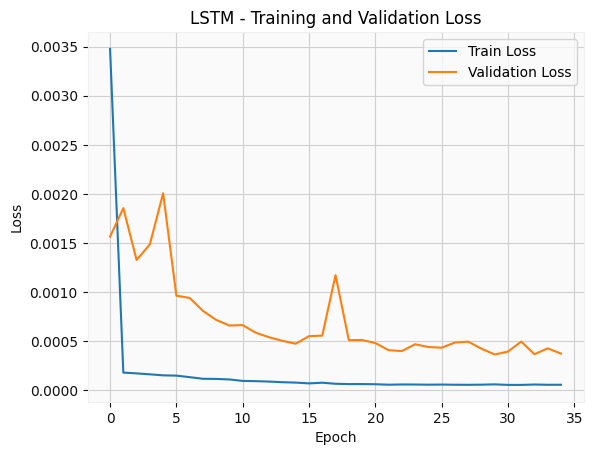

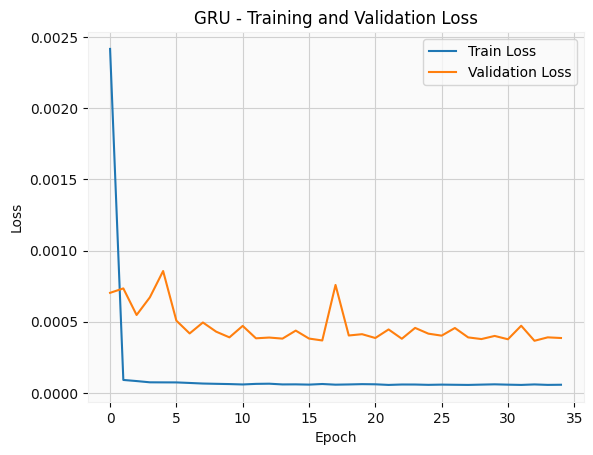

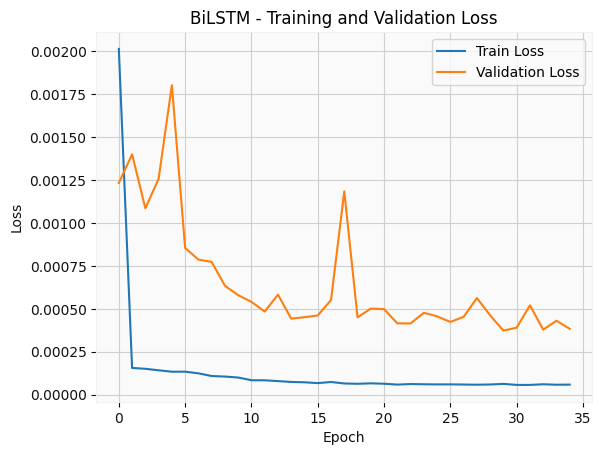

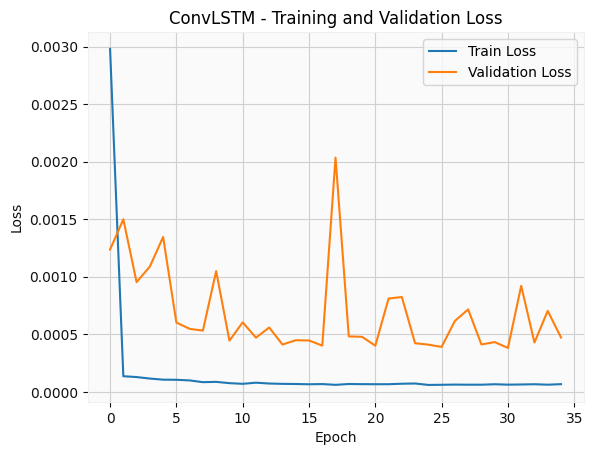

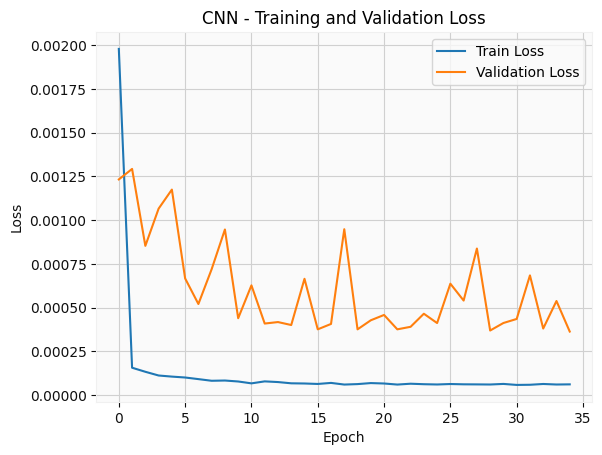

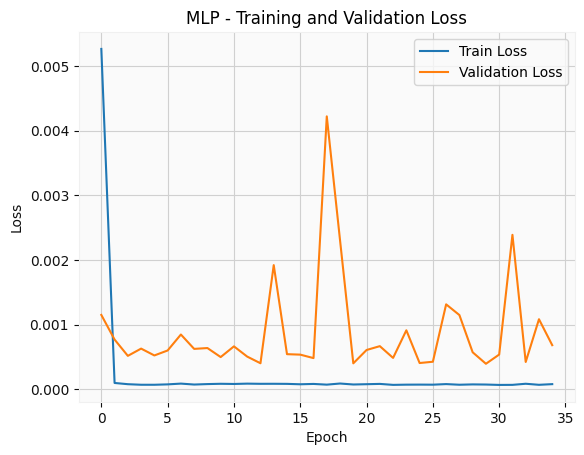

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.01, MSE: 29.60, MAPE: 1.68%
GRU - MAE: 4.11, MSE: 30.46, MAPE: 1.71%
BiLSTM - MAE: 4.08, MSE: 30.25, MAPE: 1.70%
ConvLSTM - MAE: 4.64, MSE: 37.33, MAPE: 1.86%
CNN - MAE: 3.96, MSE: 28.67, MAPE: 1.67%
MLP - MAE: 5.74, MSE: 53.92, MAPE: 2.42%
Naive Prediction - MAE: 3.97, MSE: 35.24, MAPE: 1.67%
cross validation length is 2931
(14006, 1) (14006, 10, 1)
start conv lstm
start lstm
start gru
start bilstm
start CNN
start MLP


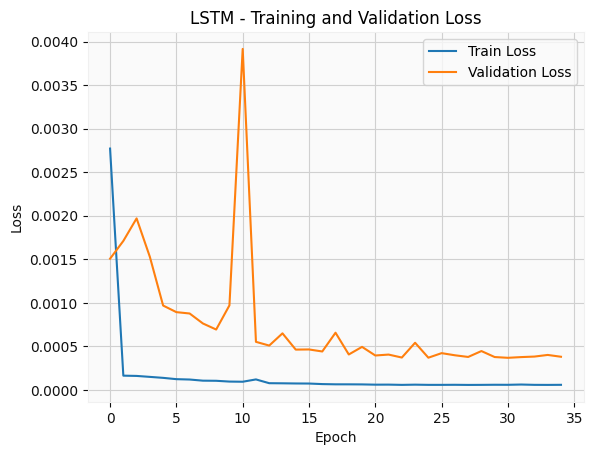

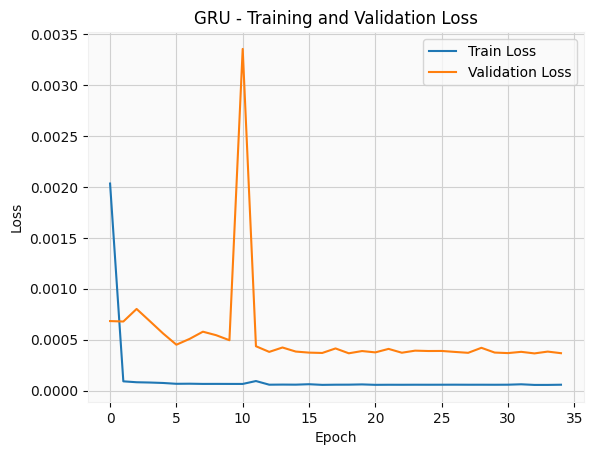

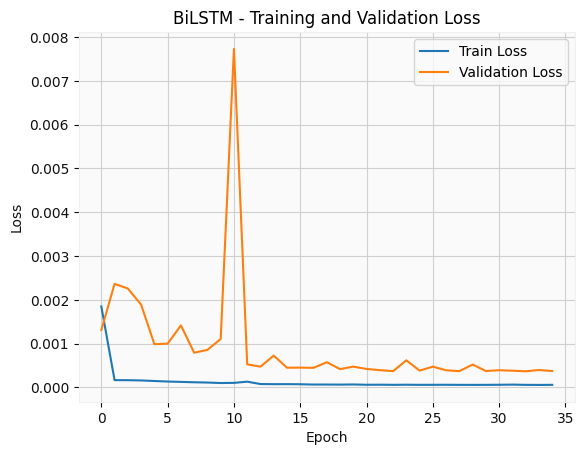

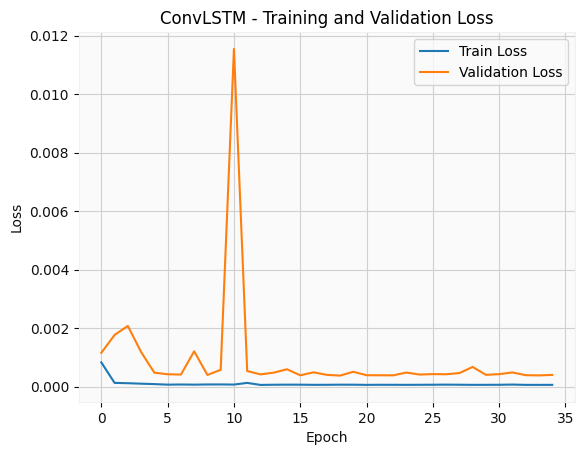

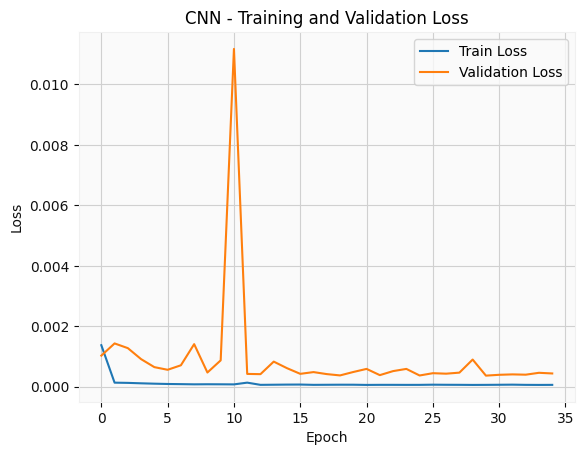

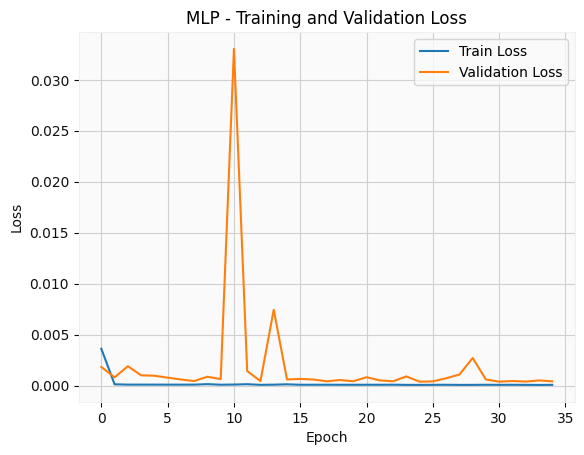

90/90 [==============================] - 0s 2ms/step
LSTM - MAE: 4.03, MSE: 30.02, MAPE: 1.71%
GRU - MAE: 3.97, MSE: 29.03, MAPE: 1.66%
BiLSTM - MAE: 3.98, MSE: 29.59, MAPE: 1.69%
ConvLSTM - MAE: 4.17, MSE: 31.72, MAPE: 1.76%
CNN - MAE: 4.39, MSE: 34.70, MAPE: 1.84%
MLP - MAE: 4.27, MSE: 32.95, MAPE: 1.80%
Naive Prediction - MAE: 3.97, MSE: 35.24, MAPE: 1.67%


In [20]:
assets = ['AMZN', 'MSFT', 'AAPL', 'META', 'GOOGL']

start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Current date

stock_data = yf.download(assets,interval='1d', start=start_date, end=end_date)['Adj Close']

window_size=10
# print(stock_data)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(stock_data):


    for seed in range(5):

        random.seed(seed)
        tf.random.set_seed(seed)
        np.random.seed(seed)

        print(f'cross validation length is {len(train_index)}')
        testy_tickers=[]
        testx_tickers=[]
        y_tickers_sp=[]
        x_tickers_sp=[]

        scaler = MinMaxScaler()

        for symbol, stock in stock_data.items():

            train_data, test_data = stock.iloc[train_index], stock.iloc[test_index]
            if len(train_data.dropna())<window_size+2: # drop training with null
              continue
            # print(symbol,train_data.shape)

            norm_transform = scaler.fit(train_data.values.reshape(-1,1))

            test_data=norm_transform.transform(test_data.dropna().values.reshape(-1,1))
            seqt, labt = create_sequences(test_data, window_size)

            testx_tickers.extend(seqt)
            testy_tickers.extend(labt)
            # print(testx_tickers[-1].shape)

            train_data=norm_transform.transform(train_data.dropna().values.reshape(-1,1))
            # print('normalized shape',train_data.shape)

            sequencest, labelst = create_sequences(train_data, window_size)
            y_tickers_sp.extend(labelst)
            x_tickers_sp.extend(sequencest)
            # print(symbol,train_data.shape)

        # print("starting cross val of size ",len(x_tickers_sp),x_tickers_sp[-3].shape)

        y_tickers_sp=np.array(y_tickers_sp).reshape(-1,1)
        x_tickers_sp=np.array(x_tickers_sp).reshape(-1,window_size,1)
        print(y_tickers_sp.shape,x_tickers_sp.shape)
        testy_tickers=np.array(testy_tickers).reshape(-1,1)
        testx_tickers=np.array(testx_tickers).reshape(-1,window_size,1)

        epochs=35
        print('start conv lstm')
        # Create and train ConvLSTM model
        convlstm_model = create_model('ConvLSTM',window_size)
        convlstm_hist=convlstm_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0)

        print('start lstm')
        lstm_model = create_model('LSTM',window_size)
        lstm_hist=lstm_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0) # Set verbose to 1 for progress bar

        print('start gru')
        # Create and train GRU model
        gru_model = create_model('GRU',window_size)
        gru_hist=gru_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0)

        print('start bilstm')
        # Create and train BiLSTM model
        bilstm_model = create_model('BiLSTM',window_size)
        bilstm_hist=bilstm_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0)

        print('start CNN')
        # Create and train CNN model
        cnn_model = create_model('CNN',window_size)
        cnn_hist=cnn_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0)

        print('start MLP')
        # Create and train MLP model
        mlp_model = create_model('MLP',window_size)
        mlp_hist=mlp_model.fit(x_tickers_sp, y_tickers_sp, epochs=epochs, batch_size=36, validation_data=(testx_tickers, testy_tickers), verbose=0)



        plot_loss(lstm_hist, 'LSTM')
        plot_loss(gru_hist, 'GRU')
        plot_loss(bilstm_hist, 'BiLSTM')
        plot_loss(convlstm_hist, 'ConvLSTM')
        plot_loss(cnn_hist, 'CNN')
        plot_loss(mlp_hist, 'MLP')

        # Evaluate LSTM model
        mae_lstm, mse_lstm, mape_lstm = evaluate_model(lstm_model, testx_tickers, testy_tickers, scaler)

        # Evaluate GRU model
        mae_gru, mse_gru, mape_gru = evaluate_model(gru_model, testx_tickers, testy_tickers, scaler)

        # Evaluate BiLSTM model
        mae_bilstm, mse_bilstm, mape_bilstm = evaluate_model(bilstm_model, testx_tickers, testy_tickers, scaler)

        # Evaluate ConvLSTM model
        mae_convlstm, mse_convlstm, mape_convlstm = evaluate_model(convlstm_model, testx_tickers, testy_tickers, scaler)

        # Evaluate CNN model
        mae_cnn, mse_cnn, mape_cnn = evaluate_model(cnn_model, testx_tickers, testy_tickers, scaler)

        # Evaluate MLP model
        mae_mlp, mse_mlp, mape_mlp = evaluate_model(mlp_model, testx_tickers, testy_tickers, scaler)

        # Print evaluation results
        print("LSTM - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_lstm, mse_lstm, mape_lstm))
        print("GRU - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_gru, mse_gru, mape_gru))
        print("BiLSTM - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_bilstm, mse_bilstm, mape_bilstm))
        print("ConvLSTM - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_convlstm, mse_convlstm, mape_convlstm))
        print("CNN - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_cnn, mse_cnn, mape_cnn))
        print("MLP - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_mlp, mse_mlp, mape_mlp))

        y_naive_pred = naive_prediction(testy_tickers)

        # Inverse transform the naive prediction and true labels to original scale
        y_naive_pred_original = scaler.inverse_transform(y_naive_pred.reshape(-1, 1))
        y_test_original = scaler.inverse_transform(testy_tickers.reshape(-1, 1))

        # Calculate evaluation metrics for the naive prediction
        mae_naive = mean_absolute_error(y_test_original, y_naive_pred_original)
        mse_naive = mean_squared_error(y_test_original, y_naive_pred_original)
        mape_naive = np.mean(np.abs((y_test_original - y_naive_pred_original) / y_test_original)) * 100

        # Print evaluation results for the naive prediction
        print("Naive Prediction - MAE: {:.2f}, MSE: {:.2f}, MAPE: {:.2f}%".format(mae_naive, mse_naive, mape_naive))

